In [104]:
"""
DD-GPCE (Data-Driven Generalized Polynomial Chaos Expansion) Library

This module contains implementations for:
1. Statistical Sampling (LHS, Inverse Transform)
2. Kernel Density Estimation (KDE) with Bias Correction
3. DD-GPCE Algorithm Core
4. Benchmark Reliability Analysis Models (10-bar Truss, Mathematical Functions)

Author: [Hojun Choi]
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.integrate as integrate
import scipy.optimize as optimize
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.neighbors import KernelDensity
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal, qmc, norm
from sympy import symbols, itermonomials, lambdify, Mul, Matrix
from sympy.polys.monomials import itermonomials
from sympy.polys.orderings import monomial_key
from sympy.utilities.lambdify import implemented_function
from scipy import stats

# ==============================================================================
# 1. Statistical Utilities & Basic Sampling
# ==============================================================================

def cal_mean_std(mu, sigma):
    """
    Converts normal distribution parameters to log-normal parameters.
    Returns: [lambda (mean of log), zeta (std of log)]
    """
    var = np.log(1 + (sigma / mu) ** 2)
    mean = np.log(mu) - var / 2
    std_dev = np.sqrt(var)
    return [mean, std_dev]

def compute_covariance_matrix(stds, rho, num_vars):
    """
    Constructs a covariance matrix given standard deviations and a constant correlation coefficient.
    """
    cov_matrix = np.zeros((num_vars, num_vars))
    np.fill_diagonal(cov_matrix, np.array(stds) ** 2)

    for i in range(num_vars):
        for j in range(i + 1, num_vars):
            cov_val = rho * stds[i] * stds[j]
            cov_matrix[i, j] = cov_val
            cov_matrix[j, i] = cov_val
    return cov_matrix

def lhs_normal(num_samples, mean, cov_matrix, seed=None):
    """
    Generates samples from a multivariate normal distribution using Latin Hypercube Sampling (LHS).
    """
    if seed is not None:
        np.random.seed(seed)
        
    num_dim = cov_matrix.shape[0]
    lhs_sampler = qmc.LatinHypercube(d=num_dim, seed=seed)
    
    # 1. Generate Uniform Samples (0, 1)
    lhs_samples_uniform = lhs_sampler.random(n=num_samples)
    
    # 2. Transform to Standard Normal
    lhs_samples_standard_normal = norm.ppf(lhs_samples_uniform)
    
    # 3. Apply Correlation (Cholesky Decomposition)
    L = np.linalg.cholesky(cov_matrix)
    lhs_samples = lhs_samples_standard_normal @ L.T + mean
    
    return lhs_samples

def silverman_bandwidth(x):
    """Calculates Silverman's Rule of Thumb bandwidth."""
    n, d = x.shape
    return (4 / (d + 2)) ** (1 / (d + 4)) * n ** (-1 / (d + 4))

def clip_to_whisker(y):
    """Clips data to the whiskers of a boxplot (1.5 IQR rule) for cleaner visualization."""
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return np.clip(y, lower, upper)

# ==============================================================================
# 2. Kernel Density Estimation (KDE) & Advanced Sampling
# ==============================================================================

def compute_kde(data, x_grid, bandwidth):
    """Computes KDE score samples on a given grid."""
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data)
    log_dens = kde.score_samples(x_grid)
    return np.exp(log_dens)

def inverse_transform_sampling(pdf_vals, num_samples, x_vals, seed=None):
    """1D Inverse Transform Sampling from a numeric PDF."""
    if seed is not None:
        np.random.seed(seed)
        
    n = len(pdf_vals)
    if x_vals is None:
        x_vals = np.linspace(0, 1, n)

    # Normalize PDF
    dx = x_vals[1] - x_vals[0]
    pdf_vals = pdf_vals / (np.sum(pdf_vals) * dx)

    # Compute CDF
    cdf_vals = np.cumsum(pdf_vals) * dx
    cdf_vals = np.clip(cdf_vals, 0, 1)

    # Inverse CDF Interpolation
    inv_cdf = interp1d(cdf_vals, x_vals, bounds_error=False, fill_value=(x_vals[0], x_vals[-1]))
    
    u = np.random.uniform(0, 1, num_samples)
    return inv_cdf(u)

def fast_2d_inverse_transform_sampling(pdf_values, x_grid, y_grid, n_samples=1000, seed=None):
    """
    Efficient 2D Inverse Transform Sampling by decomposing into Marginal (X) and Conditional (Y|X).
    """
    if seed is not None:
        np.random.seed(seed)
    
    dx = x_grid[1] - x_grid[0]
    dy = y_grid[1] - y_grid[0]

    # 1. Marginal PDF over X
    marginal_pdf_x = np.sum(pdf_values, axis=1) * dy
    marginal_cdf_x = cumtrapz(marginal_pdf_x, x_grid, initial=0)
    if marginal_cdf_x[-1] > 0:
        marginal_cdf_x /= marginal_cdf_x[-1]
    
    inv_cdf_x = interp1d(marginal_cdf_x, x_grid, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))

    # 2. Conditional CDFs (Y | X)
    conditional_cdfs_y = []
    for i in range(len(x_grid)):
        cond_pdf = pdf_values[i, :]
        total_p = cond_pdf.sum() * dy
        if total_p > 0:
            cond_pdf = cond_pdf / total_p
            cond_cdf = cumtrapz(cond_pdf, y_grid, initial=0)
            cond_cdf /= cond_cdf[-1]
        else:
            cond_cdf = np.linspace(0, 1, len(y_grid)) # Fallback to uniform
            
        conditional_cdfs_y.append(interp1d(cond_cdf, y_grid, bounds_error=False, fill_value=(y_grid[0], y_grid[-1])))

    # 3. Sampling
    u1 = np.random.uniform(0, 1, n_samples)
    x_samples = inv_cdf_x(u1)
    
    # Find nearest x index for conditional sampling
    x_indices = np.abs(x_samples[:, None] - x_grid).argmin(axis=1)
    y_samples = np.zeros(n_samples)
    
    for i in range(n_samples):
        u2 = np.random.uniform()
        y_samples[i] = conditional_cdfs_y[x_indices[i]](u2)

    return np.column_stack([x_samples, y_samples])

def kde_sampling_with_correction(kde_set, n_samples, seed=42, eps_scale=0.1):
    """
    Generalized KDE sampling with Bootstrap Bias Correction (1D & 2D supported).
    """
    eps = eps_scale # Noise scaling factor for bootstrap
    n, d = kde_set.shape
    h = silverman_bandwidth(kde_set) # Bandwidth
    
    # --- 1D Case ---
    if d == 1:
        lim_min = np.min(kde_set) - np.std(kde_set)
        lim_max = np.max(kde_set) + np.std(kde_set)
        x_grid_vals = np.linspace(lim_min, lim_max, 1000)
        grid_coords = x_grid_vals.reshape(-1, 1)
        
        # Original KDE
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(kde_set)
        kde_dens = np.exp(kde.score_samples(grid_coords))
        
        # Bootstrap Correction
        n_bootstrap = 100
        boot_sum = np.zeros_like(kde_dens)
        for _ in range(n_bootstrap):
            x_resampled = kde_set[np.random.choice(n, n, replace=True)]
            noise = np.random.normal(0, eps, size=(n, 1))
            boot_sum += compute_kde(x_resampled + noise * h, grid_coords, h)
            
        bias_corrected = 2 * kde_dens - (boot_sum / n_bootstrap)
        samples = inverse_transform_sampling(bias_corrected, n_samples, x_grid_vals, seed=seed)
        return (samples / np.mean(samples)).reshape(-1, 1)

    # --- 2D Case ---
    else: 
        lim_min = np.min(kde_set, axis=0) - np.std(kde_set, axis=0)
        lim_max = np.max(kde_set, axis=0) + np.std(kde_set, axis=0)
        
        x_axes = np.linspace(lim_min[0], lim_max[0], 100)
        y_axes = np.linspace(lim_min[1], lim_max[1], 100)
        xx, yy = np.meshgrid(x_axes, y_axes, indexing='ij')
        grid_coords = np.vstack([xx.ravel(), yy.ravel()]).T
        
        # Original KDE
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(kde_set)
        kde_dens = np.exp(kde.score_samples(grid_coords)).reshape(100, 100)
        
        # Bootstrap Correction
        n_bootstrap = 100
        boot_sum = np.zeros_like(kde_dens)
        for _ in range(n_bootstrap):
            x_resampled = kde_set[np.random.choice(n, n, replace=True)]
            noise = np.random.normal(0, eps, size=(n, d))
            boot_kde_val = compute_kde(x_resampled + noise * h, grid_coords, h)
            boot_sum += boot_kde_val.reshape(100, 100)
            
        bias_corrected = 2 * kde_dens - (boot_sum / n_bootstrap)
        samples = fast_2d_inverse_transform_sampling(bias_corrected, x_axes, y_axes, n_samples, seed=seed)
        return samples / np.mean(samples, axis=0)

def kde_sampling_1d_corrected(data_1d, n_samples, seed=None, n_bootstrap=100, eps=0.1, grid_points=5000):
    """
    Performs 1D KDE Fitting -> Bootstrap Bias Correction -> Inverse Transform Sampling.
    
    Args:
        data_1d (np.array): 1D array of training data (N, 1).
        n_samples (int): Number of samples to generate.
        seed (int): Random seed.
        n_bootstrap (int): Number of bootstrap iterations.
        eps (float): Noise scale for bootstrap.
        grid_points (int): Resolution of the grid for PDF estimation.
        
    Returns:
        np.array: Generated samples (1D).
    """
    n = len(data_1d)
    
    # 1. Define Grid (Adaptive range)
    std_val = np.std(data_1d)
    lim_min = np.min(data_1d) - std_val
    lim_max = np.max(data_1d) + std_val
    x_grid = np.linspace(lim_min, lim_max, grid_points)
    grid_coords = x_grid.reshape(-1, 1)
    
    # 2. Calculate Bandwidth (Silverman's Rule)
    # d=1 case simplification: h = 1.06 * std * n^(-1/5) or similar
    # Using the formula from your snippet:
    d = 1
    h = (n * (d + 2) / 4) ** (-1 / (d + 4)) 
    
    # 3. Original KDE Fitting
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(data_1d)
    log_dens = kde.score_samples(grid_coords)
    kde_dens = np.exp(log_dens)
    
    # 4. Bootstrap Bias Correction
    boot_sum = np.zeros_like(kde_dens)
    rng = np.random.default_rng(seed)
    
    for _ in range(n_bootstrap):
        # Resampling
        indices = rng.choice(n, n, replace=True)
        x_resampled = data_1d[indices]
        
        # Add Noise
        noise = rng.normal(0, eps, size=(n, 1))
        x_plus = x_resampled + noise * h
        
        # KDE on resampled data
        kde_boot = KernelDensity(kernel='gaussian', bandwidth=h).fit(x_plus)
        boot_sum += np.exp(kde_boot.score_samples(grid_coords))
        
    # Bias Corrected Density
    bias_corrected = 2 * kde_dens - (boot_sum / n_bootstrap)
    
    # 5. Inverse Transform Sampling
    # Using the 'inverse_transform_sampling' utility defined in previous steps
    samples = inverse_transform_sampling(bias_corrected, n_samples, x_grid, seed=seed)
    
    return samples

def grid_based_sampling(pdf_values, grid_coords, n_samples=1000, bandwidth=0.1, seed=42):
    """
    Performs weighted sampling based on PDF values on a grid, followed by jittering.
    
    Args:
        pdf_values: PDF probability at each grid point.
        grid_coords: Coordinates of grid points.
        bandwidth: Bandwidth used for jittering (smoothing).
    """
    rng = np.random.default_rng(seed)
    
    # Ensure non-negative probabilities
    safe_pdf = np.maximum(pdf_values, 0)
    total_prob = np.sum(safe_pdf)
    
    # Normalize probabilities
    if total_prob == 0:
        probs = np.ones_like(safe_pdf) / len(safe_pdf)
    else:
        probs = safe_pdf / total_prob
    
    # 1. Weighted Choice of Indices
    indices = rng.choice(len(probs), size=n_samples, p=probs)
    sampled_points = grid_coords[indices]
    
    # 2. Add Jitter (Smoothing)
    d = grid_coords.shape[1]
    jitter = rng.normal(0, bandwidth, size=(n_samples, d))
    
    return sampled_points + jitter

def run_7d_kde_correction(kde_set, bin_size, n_samples=1000, eps=0.1, seed=42):
    """
    Runs KDE fitting with Bootstrap Bias Correction on a high-dimensional grid.
    
    Args:
        kde_set: Input training data (N, d).
        bin_size: Number of grid points per dimension.
        n_samples: Number of samples to generate.
        eps: Noise scale for bootstrap.
    """
    n = len(kde_set)
    d = kde_set.shape[1]
    rng = np.random.default_rng(seed)

    print(f"Initializing {d}D Grid (Bins={bin_size})... This may take memory.")

    # 1. Initialize Grid
    # Define bounds based on data range + std deviation buffer
    std_vec = np.std(kde_set, axis=0)
    lim_min = np.min(kde_set, axis=0) - std_vec
    lim_max = np.max(kde_set, axis=0) + std_vec

    # Create axes for meshgrid
    axes = [np.linspace(l_min, l_max, bin_size) for l_min, l_max in zip(lim_min, lim_max)]
    
    # Generate Grid Points (Memory Intensive for High D!)
    # indexing='ij' ensures correct dimension ordering
    mesh = np.meshgrid(*axes, indexing='ij')
    grid_coords = np.vstack([m.ravel() for m in mesh]).T.astype(np.float32)

    # Calculate Bandwidth (Silverman's Rule - Isotropic approximation using first dim scale)
    # Note: Assuming variables have similar scales (Log-Normal Group 1). 
    # If scales differ significantly, use per-dimension bandwidth.
    scale_std = std_vec[0] 
    h = (4 / (d + 2)) ** (1 / (d + 4)) * n ** (-1 / (d + 4)) * scale_std

    print(f"Grid Points: {len(grid_coords):,}")
    print("Running Original KDE...")

    # 2. Original KDE Fitting
    # Using 'compute_kde' from the library
    kde_dens = compute_kde(kde_set, grid_coords, h) 

    # 3. Bootstrap Bias Correction
    print("Running Bootstrap Bias Correction...")
    n_bootstrap = 100 
    boot_kdes_sum = np.zeros_like(kde_dens)

    for i in range(n_bootstrap):
        # Resample with replacement
        indices = rng.choice(n, n, replace=True)
        x_star = kde_set[indices]
        
        # Add perturbation noise
        epsilon_noise = rng.normal(0, eps, size=x_star.shape)
        x_plus = x_star + epsilon_noise * h
        
        # Compute KDE on perturbed data
        dens = compute_kde(x_plus, grid_coords, h)
        boot_kdes_sum += dens
    
    # Calculate corrected density
    boot_kdes_mean = boot_kdes_sum / n_bootstrap
    bias_corrected = 2 * kde_dens - boot_kdes_mean

    # 4. Sampling and Normalization
    print("Sampling from Corrected Density...")
    samples = grid_based_sampling(bias_corrected, grid_coords, n_samples, bandwidth=h, seed=seed)
    
    # Normalize (Basis construction requires mean=1)
    samples_norm = samples / np.mean(samples, axis=0)
    
    return samples, samples_norm

def run_single_kde_correction(data_col, n_samples, seed, scale=1.0, 
                              use_std_bandwidth=False, eps=0.1):
    """
    Performs 1D KDE fitting, Bootstrap Bias Correction, and Inverse Transform Sampling.
    Maintains exact logic from original snippets.
    """
    # 1. Apply Scaling
    kde_set = data_col / scale
    
    # 2. Initialize Grid
    lim_min = np.min(kde_set) - np.std(kde_set)
    lim_max = np.max(kde_set) + np.std(kde_set)
    x = np.mgrid[lim_min:lim_max:5000j]
    grid_coords = np.vstack([x.ravel()])
    
    # 3. Calculate Bandwidth (h)
    n, d = kde_set.shape
    h = (4/(d+2))**(1/(d+4))*n**(-1/(d+4))
    
    # Special condition from original code (Block 3, i=0)
    if use_std_bandwidth:
        h *= np.std(kde_set)
        
    # 4. Original KDE Fitting
    kde_orign = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_orign.fit(kde_set)
    kde_dens = np.exp(kde_orign.score_samples(grid_coords.T)).reshape(x.shape[0])
    
    # 5. Bootstrap Bias Correction
    n_bootstrap = 100
    boot_kdes = []
    
    # Note: Using global np.random state here to match original snippet's behavior
    for _ in range(n_bootstrap):
        x_star = kde_set[np.random.choice(n, n, replace=True)]
        epsilon = np.random.normal(0, eps, size=n).reshape(-1, 1)
        x_plus = x_star + epsilon * h
        # Assuming compute_kde is defined globally
        boot_kdes.append(compute_kde(x_plus, grid_coords.T, h).reshape(x.shape[0]))
        
    boot_kdes = np.array(boot_kdes)
    bias_corrected = 2 * kde_dens - boot_kdes.mean(axis=0)
    
    # 6. Sampling
    x_axes = np.linspace(lim_min, lim_max, 5000)
    # Assuming inverse_transform_sampling is defined globally
    kde_sample = inverse_transform_sampling(bias_corrected, n_samples, x_axes, seed=seed)
    
    # 7. Reverse Scaling
    return kde_sample * scale

def cal_mean_std(mu, sigma):
    """
    Converts Log-Normal parameters (mean, std) to underlying Normal parameters.
    """
    var = np.log(1 + (sigma/mu)**2)
    mean = np.log(mu) - var / 2
    std_dev = np.sqrt(var)
    return [mean, std_dev]

def compute_covariance_matrix_multi(standard_deviations, correlation_coefficient, num_variables):
    """
    Constructs a covariance matrix with constant correlation.
    """
    covariance_matrix = np.zeros((num_variables, num_variables))
    np.fill_diagonal(covariance_matrix, np.array(standard_deviations) ** 2)

    for i in range(num_variables):
        for j in range(i + 1, num_variables):
            covariance_matrix[i, j] = correlation_coefficient * standard_deviations[i] * standard_deviations[j]
            covariance_matrix[j, i] = covariance_matrix[i, j]

    return covariance_matrix

def sampling(log_mean, log_cov, cor_coef, samping_number, seed):
    """
    Generates samples for Log-Normal variables.
    Returns the underlying Normal samples (ln_X).
    """
    # log_cov here is passed as Variance (std**2)
    log_sig = np.sqrt(log_cov) 
    
    # Calculate underlying Normal parameters
    gau_mean, gau_sigma = cal_mean_std(log_mean, log_sig)

    # Compute Covariance Matrix for underlying Normal
    gau_cov = compute_covariance_matrix_multi(gau_sigma, cor_coef, len(gau_mean))

    # Generate samples (lhs_normal returns Normal samples)
    # Note: Assumes 'lhs_normal' is defined in the library
    samples = lhs_normal(samping_number, gau_mean, gau_cov, seed)
    return samples

# ==============================================================================
# 3. DD-GPCE Algorithm
# ==============================================================================

def DD_GenP(x, m, S):
    """
    Generates the polynomial basis matrix (P_m) for DD-GPCE using SymPy.
    
    Args:
        x: Input samples (N_samples, N_vars)
        m: Maximum order of polynomials
        S: Sparsity parameter (max terms in a monomial)
    """
    N_samples, N_vars = x.shape
    sym_vars = symbols(f'x:{N_vars}') 
    
    # Generate monomials in Graded Lexicographic order
    P_monomials = sorted(itermonomials(sym_vars, m), 
                         key=monomial_key('grlex', list(reversed(sym_vars))))
    
    var_dict = dict(zip(sym_vars, x.T))
    Pm = np.ones((1, N_samples)) # Initialize with bias term (1)
    
    for monomial in P_monomials[1:]: # Skip the first term if it's 1
        terms = Mul.make_args(monomial)
        
        # Sparsity Check
        if len(terms) <= S:
            # Decompose monomial bases
            mono_bases = [t.as_base_exp()[0] for t in terms]
            
            # Create vectorized function
            f = lambdify(mono_bases, monomial, 'numpy')
            
            # Prepare input data for this monomial
            if monomial.is_Pow:
                input_vals = var_dict[mono_bases[0]]
                mono_val = f(input_vals)
            elif monomial.is_Mul:
                input_vals = [var_dict[b] for b in mono_bases]
                mono_val = f(*input_vals)
            else: # Single variable
                mono_val = var_dict[monomial]
            
            # Ensure shape consistency and stack
            mono_val = np.array(mono_val).reshape(1, -1)
            Pm = np.concatenate((Pm, mono_val), axis=0)
            
    return Pm

def run_dd_gpce(x_target, x_train, y_train, order, S):
    """
    Executes the Data-Driven GPCE algorithm.
    
    Args:
        x_target: Samples defining the target distribution (unlabeled).
        x_train: Training samples (labeled).
        y_train: Training labels (responses).
        order: Polynomial order.
        S: Sparsity.
    """
    # 1. Orthogonalization via Cholesky
    P = DD_GenP(x_target, order, S)
    G = (P @ P.T) / len(x_target)
    Q = np.linalg.cholesky(G)
    W = np.linalg.inv(Q) # Whitening matrix
    
    # 2. Coefficient Estimation (Least Squares)
    P_train = DD_GenP(x_train, order, S)
    A = (W @ P_train).T
    B = y_train
    
    # Solve C = (A^T A)^-1 A^T B
    C = np.linalg.inv(A.T @ A) @ A.T @ B
    
    # 3. Moment Estimation
    gpce_mean = C[0]
    gpce_var = np.sum(C**2) - C[0]**2
    
    return gpce_mean, gpce_var

def extract_variable_indices(expr, variables):
    used_vars = set()
    for term in Mul.make_args(expr):
        base = term.as_base_exp()[0]
        if base in variables:
            used_vars.add(base)
    return sorted([variables.index(v) for v in used_vars])

def build_symbolic_basis(N, m, S):
    """
    Constructs the symbolic monomial basis P and the symbolic moment matrix G.
    """
    variables = symbols(f'x:{N}')
    # Generate all monomials up to degree m
    P_all = sorted(itermonomials(variables, m), 
                   key=monomial_key('grlex', list(reversed(variables))))
    
    # Filter based on sparsity S (max interaction order)
    P = []
    for mono in P_all:
        # Check number of variables in the monomial
        if len(extract_variable_indices(mono, variables)) <= S:
            P.append(mono)
            
    P_matrix = Matrix(P)
    G_symbolic = P_matrix * P_matrix.T
    
    return variables, P, G_symbolic

def compute_numeric_moment_matrix(G_symbolic, variables, x_train_samples, n_gen_samples):
    """
    Computes the numeric moment matrix using KDE sampling and integration.
    """
    n_basis = G_symbolic.shape[0]
    G_numeric = np.zeros((n_basis, n_basis))
    
    # Cache for generated samples: key=tuple(indices), value=samples
    kde_sample_cache = {} 
    
    # Iterate Upper Triangle
    for i in range(n_basis):
        for j in range(i, n_basis):
            expr = G_symbolic[i, j]
            
            # A. Identify Variables Involved
            var_indices = tuple(extract_variable_indices(expr, variables))
            
            # B. Get Samples (Cache or Generate)
            if not var_indices:
                # Constant term (no variables)
                val = float(expr) # Usually 1.0
                G_numeric[i, j] = val
                G_numeric[j, i] = val
                continue
                
            if var_indices in kde_sample_cache:
                current_samples = kde_sample_cache[var_indices]
            else:
                # Generate new samples using KDE
                # Extract columns for relevant variables
                reduced_data = x_train_samples[:, var_indices]
                
                # Perform KDE sampling
                # Using seed=42 as in original code, or pass dynamic seed if needed
                current_samples = kde_sampling_with_correction(reduced_data, n_gen_samples, seed=42)
                kde_sample_cache[var_indices] = current_samples
            
            # C. Numerical Integration (Expectation)
            # Lambdify the expression
            # Extract symbols corresponding to indices
            active_vars = [variables[k] for k in var_indices]
            func = lambdify(active_vars, expr, modules='numpy')
            
            # Evaluate expression on samples
            # *current_samples.T unpacks columns to arguments
            evaluated_values = func(*current_samples.T)
            
            expectation_val = np.mean(evaluated_values)
            
            # Fill Symmetric Matrix
            G_numeric[i, j] = expectation_val
            G_numeric[j, i] = expectation_val
            
    return G_numeric

def run_gpce_solver(basis_samples, train_x, train_y, m, S, method_name):
    """
    Core GPCE solver that handles Basis Construction, Matrix Conditioning, 
    and Coefficient Estimation.
    """
    print(f"[{method_name}] Running GPCE (m={m}, S={S})...")
    
    # 1. Basis Normalization
    # Basis samples define the orthogonality (G matrix)
    basis_mean = np.mean(basis_samples, axis=0)
    basis_norm = basis_samples / basis_mean
    
    # 2. Moment Matrix (G) Construction
    N_basis = basis_samples.shape[0]
    P_basis = DD_GenP(basis_norm, m, S)
    G = (P_basis @ P_basis.T) / N_basis
    
    # 3. Matrix Conditioning (PosDef & Cholesky)
    try:
        eigvals, eigvecs = np.linalg.eigh(G)
        eigvals_corrected = np.maximum(eigvals, 1e-14)
        G_posdef = eigvecs @ np.diag(eigvals_corrected) @ eigvecs.T
        
        Q = np.linalg.cholesky(G_posdef)
        W = np.linalg.inv(Q)
    except np.linalg.LinAlgError:
        print(f"[{method_name}] Cholesky Decomposition Failed!")
        return None, None

    # 4. Coefficient Estimation
    # Normalize training data using its own mean (or basis mean, generally own mean for DD)
    # Note: For Classic, train_x usually comes from the True distribution as well.
    # Here we stick to the provided logic: normalize x_samples by its own mean.
    train_x_norm = train_x / np.mean(train_x, axis=0)
    
    P_train = DD_GenP(train_x_norm, m, S)
    A = (W @ P_train).T
    
    # Pre-compute Pseudo-Inverse: (A^T A)^-1 A^T
    # Using pinv for numerical stability
    A_pinv = np.linalg.pinv(A.T @ A) @ A.T
    
    # 5. Solve for All Outputs
    means = []
    vars_ = []
    
    for k in range(train_y.shape[1]):
        B = train_y[:, k]
        C = A_pinv @ B
        
        # Calculate Stats
        est_mean = C[0]
        est_var = np.sum(C**2) - C[0]**2
        
        means.append(est_mean)
        vars_.append(est_var)
        
    return np.array(means), np.sqrt(np.maximum(vars_, 0))

# ==============================================================================
# 4. Benchmark Models
# ==============================================================================

def limit_state_function_math(x_samples):
    """Mathematical benchmark limit state function."""
    x1 = x_samples[:, 0]
    x2 = x_samples[:, 1]
    y = 2500 - 0.5 * ((2/15)*x1 - (1/180)*x2**2)**2
    return y 

def solve_10bar_truss(X, constraint_type='cnstn'):
    """
    10-Bar Truss Finite Element Solver.
    
    Args:
        X: Design variables (Cross-sectional areas or material props).
        constraint_type: Type of constraint to check.
    
    Returns:
        np.array: [Displacement Performance, Stress Performance]
    """
    nElem = 10
    nDof = 2
    nNode = 6
    PV = -1E5 # Load (lbf)
    L_truss = 360 # Length (in)
    E = 10**7 # Modulus
    C = E / L_truss 

    # Element Connectivity
    elem = np.array([
        [1, 2], [2, 3], [3, 6], [5, 6], [4, 5],
        [1, 5], [2, 4], [2, 5], [2, 6], [3, 5]
    ]) - 1 

    KK = np.zeros((nDof * nNode, nDof * nNode))
    FF = np.zeros(nDof * nNode)
    UU = np.zeros(nDof * nNode)

    # Transformation Matrices
    a1, a2 = mt.cos(mt.pi/4), mt.sin(mt.pi/4)
    b1, b2 = -mt.cos(mt.pi/4), mt.sin(mt.pi/4)
    Trans_A = np.array([[a1, a2, 0, 0], [-a2, a1, 0, 0], [0, 0, a1, a2], [0, 0, -a2, a1]])
    Trans_B = np.array([[b1, b2, 0, 0], [-b2, b1, 0, 0], [0, 0, b1, b2], [0, 0, -b2, b1]])
    
    # Stiffness Matrix Assembly
    for ii in range(nElem):
        idx = [elem[ii, 0]*2, elem[ii, 0]*2+1, elem[ii, 1]*2, elem[ii, 1]*2+1]
        
        # Local to Global Stiffness
        if ii in [0, 1, 3, 4]: # Horizontal
            k_local = np.array([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]])
            KK[np.ix_(idx, idx)] += X[ii] * C * k_local
        elif ii in [2, 7]: # Vertical
            k_local = np.array([[0, 0, 0, 0], [0, 1, 0, -1], [0, 0, 0, 0], [0, -1, 0, 1]])
            KK[np.ix_(idx, idx)] += X[ii] * C * k_local
        elif ii in [5, 8]: # Diagonal A
            k_local = np.array([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]])
            KK[np.ix_(idx, idx)] += X[ii] * (C / np.sqrt(2)) * Trans_A.T @ k_local @ Trans_A
        elif ii in [6, 9]: # Diagonal B
            k_local = np.array([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]])
            KK[np.ix_(idx, idx)] += X[ii] * (C / np.sqrt(2)) * Trans_B.T @ k_local @ Trans_B

    # Apply Loads & BCs
    FF[2*nDof-1] = PV
    FF[3*nDof-1] = PV
    
    # Fixed nodes: 1 and 4 (Indices 0,1 and 6,7)
    fixed_dofs = [0, 1, 6, 7]
    free_dofs = [i for i in range(nDof * nNode) if i not in fixed_dofs]
    
    K_reduced = KK[np.ix_(free_dofs, free_dofs)]
    F_reduced = FF[free_dofs]
    
    # Solve
    U_reduced = np.linalg.solve(K_reduced, F_reduced)
    UU[free_dofs] = U_reduced
    
    # Compute Stress (Element 1) & Displacement (Node 2 vertical)
    # Note: Simplified calculation for Element 1 Stress
    idx_el0 = [0, 1, 2, 3] 
    S_el0 = C * np.array([-1, 0, 1, 0]) @ UU[idx_el0]
    
    Y_Disp = 1.7 - abs(UU[5]) # Node 3 vertical displacement (index 5)
    Y_Stress = 10800 - abs(S_el0)
    
    return np.array([Y_Disp, Y_Stress])

# ==============================================================================
# 4. Joint Distribution Sampling (Exponential Case)
# Implements Rosenblatt Transformation with Numerical Inversion
# ==============================================================================

def joint_pdf(x1, x2):
    if x1 < 0 or x2 < 0:
        return 0
    else:
        return np.exp(-(x1 + x2 + x1 * x2)) * ((1 + x1) * (1 + x2) - 1)


def marginal_pdf_x1(x1):
    if x1 < 0:
        return 0
    integrand = lambda x2: joint_pdf(x1, x2)
    result, _ = integrate.quad(integrand, 0, np.inf)
    return result


def cdf_x1(x1):
    if x1 < 0:
        return 0
    # integrand = lambda t: marginal_pdf_x1(t)
    # result, _ = integrate.quad(integrand, 0, x1)
    result = 1 - np.exp(-x1)
    return result

def inverse_cdf_x1(u,initial_bracket = (0,100), max_iter = 10, step_size = 10):
    low, high = initial_bracket
    for _ in range(max_iter):
        result = optimize.root_scalar(lambda x: cdf_x1(x) - u, bracket=[low, high])
        if result.converged:
            return result.root
        high += step_size


def conditional_pdf_x2_given_x1(x2, x1):
    return joint_pdf(x1, x2) / marginal_pdf_x1(x1)


def cdf_x2_given_x1(x2, x1):
    if x2 < 0:
        return 0
    integrand = lambda t: conditional_pdf_x2_given_x1(t, x1)
    result, _ = integrate.quad(integrand, 0, x2)
    return result

def inverse_cdf_x2_given_x1(u, x1, initial_bracket = (0,100), max_iter = 10, step_size = 10):
    def func(x):
        return cdf_x2_given_x1(x,x1)-u
    
    low, high = initial_bracket
    for _ in range(max_iter):
        if func(low) * func(high) < 0:
            result = optimize.root_scalar(func, bracket=[low,high])
            if result.converged:
                return result.root
        high += step_size
    
    raise ValueError("Could not find a valid bracket where the function chages sign")

def Exponential_sampling(size, seed):
    """
    Generate samples from the joint distribution using inverse transform sampling.
    """
   
    sampler = qmc.LatinHypercube(d=2, seed=seed)

  
    u = sampler.random(n=size)
    u1, u2 = u[:, 0], u[:, 1]

   
    samples = []
    for i in range(size):
        x1 = inverse_cdf_x1(u1[i])
        x2 = inverse_cdf_x2_given_x1(u2[i], x1)
        samples.append((x1, x2))

    return np.array(samples)

## Example 1: Mathematical function
### Case 1

In [9]:
GPCE_seed_list = [105, 30, 127, 530, 160, 851, 566, 180, 77, 716, 119, 293, 451, 406, 844, 115, 363, 45, 450, 3216]

In [ ]:
# ==============================================================================
# Main Execution Loop
# ==============================================================================

# Note: Ensure 'GPCE_seed_list' is defined in previous cells.
# Example: GPCE_seed_list = [105, 30, 127] 

Gaussian_kde_sample_list = []

print("KDE Sampling & Correction Started...")

for seed in GPCE_seed_list:
    # Simulation Parameters
    mean = [30, 30]
    std = 3.5
    rho = 0.5
    
    # Compute Covariance Matrix
    cov_matrix = np.array([[std**2, rho*std**2], [rho*std**2, std**2]])
    
    # 1. Generate Training Data (LHS)
    # Using the refactored 'lhs_normal' function
    x_train = lhs_normal(50, mean, cov_matrix, seed=seed)
    
    # (Optional) Generate MCS samples if needed for validation
    # x_MCS = lhs_normal(10000, mean, cov_matrix, seed=seed)

    # 2. KDE Fitting -> Bootstrap Correction -> Sampling
    # Replaces the complex loop logic with a single function call
    kde_samples_norm = kde_sampling_with_correction(
        kde_set=x_train, 
        n_samples=500000, 
        seed=seed
    )
    
    # Store the generated samples
    Gaussian_kde_sample_list.append(kde_samples_norm)

print(f"Completed. Generated {len(Gaussian_kde_sample_list)} sample sets.")

In [12]:
# ==============================================================================
# Unified Simulation: DD-GPCE (Order=4, Sparsity S=2 & S=1)
# ==============================================================================

# 1. Setup Ground Truth (MCS)
# Ensure 'lhs_normal' and 'limit_state_function_math' (aliased as Y) are defined.
mean = [30, 30]
std = 3.5
rho = 0.5
cov_matrix = np.array([[std**2, rho*std**2], [rho*std**2, std**2]])
Y = limit_state_function_math

# Generate large-scale MCS samples for reference
x_MCS = lhs_normal(1000000, mean, cov_matrix, seed=42)
y_MCS = Y(x_MCS)
true_mean_ref = np.mean(y_MCS)
true_std_ref = np.std(y_MCS)

print(f"Reference MCS Mean: {true_mean_ref:.4f}, Std: {true_std_ref:.4f}")

# 2. Initialize Results Containers
metrics = ['mean', 'std', 'error_mean', 'error_std']

# Define which methods apply to which sparsity
# S=2: All methods (Data-Driven, Classic-Est, Classic-True)
# S=1: Only Data-Driven and Classic-Est
results = {
    's2': {
        'dd': {m: [] for m in metrics}, 
        'classic_est': {m: [] for m in metrics}, 
        'classic_true': {m: [] for m in metrics}
    },
    's1': {
        'dd': {m: [] for m in metrics}, 
        'classic_est': {m: [] for m in metrics}
        # 'classic_true' is excluded for S=1
    }
}

# Parameters
order = 4
sparsities = [2, 1]  # S values to loop over

# ==============================================================================
# Main Comparative Simulation Loop
# ==============================================================================

print("Starting Unified Simulation...")

for i, seed in enumerate(GPCE_seed_list):
    
    # -------------------------------------------------------
    # A. Common Data Generation (Per Seed)
    # -------------------------------------------------------
    # 1. Training Data (Small sample)
    x_train = lhs_normal(50, mean, cov_matrix, seed=seed)
    y_train = Y(x_train)
    x_train_norm = x_train / np.mean(x_train, axis=0)
    
    # 2. Classic Estimation Parameters
    est_mean = np.mean(x_train, axis=0)
    est_cov = np.cov(x_train.T)
    
    # 3. Sample Generation for different methods
    # Method 1 Input: Data-Driven (KDE)
    kde_samples = Gaussian_kde_sample_list[i]
    kde_samples_norm = kde_samples / np.mean(kde_samples, axis=0)
    
    # Method 2 Input: Classic (Estimated Gaussian)
    est_samples = lhs_normal(500000, est_mean, est_cov, seed=seed)
    est_samples_norm = est_samples / np.mean(est_samples, axis=0)
    
    # Method 3 Input: Classic (True Gaussian) - Only needed for S=2
    true_dist_samples = lhs_normal(1000000, mean, cov_matrix, seed=seed)

    # -------------------------------------------------------
    # B. Run GPCE for S=2 and S=1
    # -------------------------------------------------------
    for S in sparsities:
        key = f's{S}' # 's2' or 's1'
        
        # --- Method 1: DD-GPCE ---
        mu_dd, var_dd = run_dd_gpce(kde_samples_norm, x_train_norm, y_train, order, S)
        results[key]['dd']['mean'].append(mu_dd)
        results[key]['dd']['std'].append(np.sqrt(var_dd))
        results[key]['dd']['error_mean'].append(abs(mu_dd - true_mean_ref)/true_mean_ref * 100)
        results[key]['dd']['error_std'].append(abs(np.sqrt(var_dd) - true_std_ref)/true_std_ref * 100)
        
        # --- Method 2: Classic GPCE (Estimated) ---
        mu_cl, var_cl = run_dd_gpce(est_samples_norm, x_train_norm, y_train, order, S)
        results[key]['classic_est']['mean'].append(mu_cl)
        results[key]['classic_est']['std'].append(np.sqrt(var_cl))
        results[key]['classic_est']['error_mean'].append(abs(mu_cl - true_mean_ref)/true_mean_ref * 100)
        results[key]['classic_est']['error_std'].append(abs(np.sqrt(var_cl) - true_std_ref)/true_std_ref * 100)
        
        # --- Method 3: Classic GPCE (True) -> Only for S=2 ---
        if S == 2:
            # Note: Using raw 'true_dist_samples' and 'x_train' as per convention for True case
            mu_tr, var_tr = run_dd_gpce(true_dist_samples, x_train, y_train, order, S)
            
            results[key]['classic_true']['mean'].append(mu_tr)
            results[key]['classic_true']['std'].append(np.sqrt(var_tr))
            results[key]['classic_true']['error_mean'].append(abs(mu_tr - true_mean_ref)/true_mean_ref * 100)
            results[key]['classic_true']['error_std'].append(abs(np.sqrt(var_tr) - true_std_ref)/true_std_ref * 100)

print("Simulation Complete.")

Reference MCS Mean: 2498.9077, Std: 1.4717
Starting Unified Simulation...
Simulation Complete.


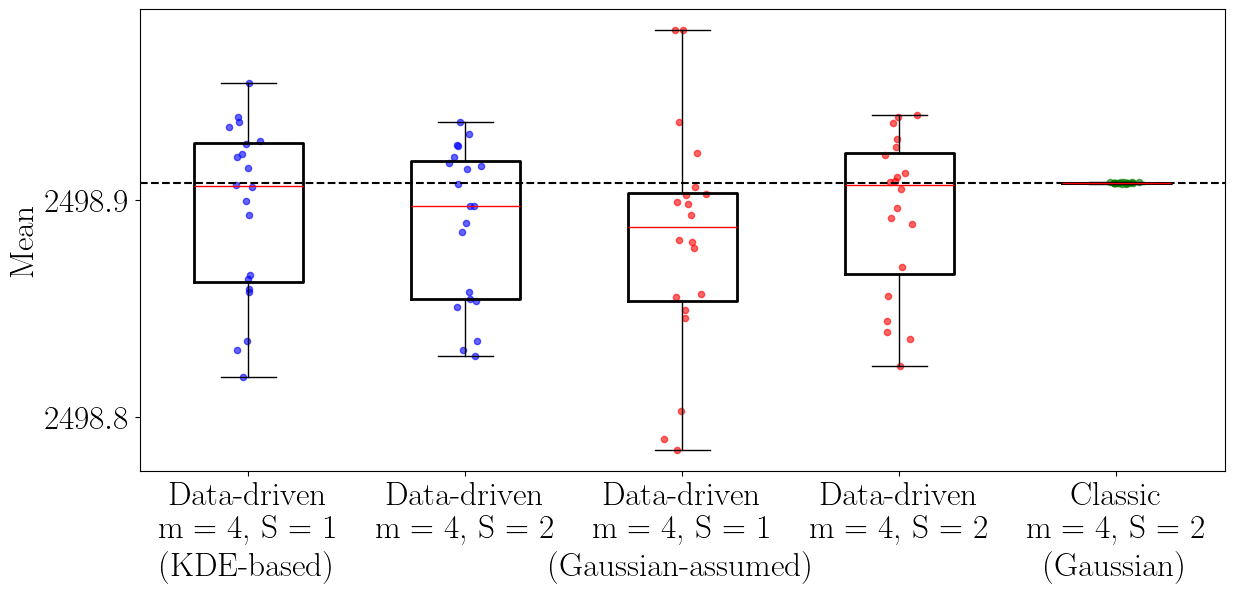

In [15]:
# ==============================================================================
# Visualization: Boxplot of Estimated Means (Original Style)
# ==============================================================================

# 1. Figure Style Configuration (User's Original Settings)
plt.style.use('default')
plt.rcParams['text.usetex'] = True   
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24

# 2. Data Preparation
# Fetching data from the unified 'results' dictionary
data = [
    results['s1']['dd']['mean'],            # 1. DD (S=1)
    results['s2']['dd']['mean'],            # 2. DD (S=2)
    results['s1']['classic_est']['mean'],   # 3. Classic Est (S=1)
    results['s2']['classic_est']['mean'],   # 4. Classic Est (S=2)
    results['s2']['classic_true']['mean']   # 5. Classic True (S=2)
]

# Apply outlier clipping (Using previously defined function)
clipped_data = [clip_to_whisker(np.array(y)) for y in data]

# Labels (User's Original Labels)
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Gaussian)'
]

# 3. Plotting
fig, ax = plt.subplots()

# Boxplot
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
ax.boxplot(clipped_data, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot (Jitter)
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y, color) in enumerate(zip(clipped_data, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

# Reference Line & Labels
ax.set_ylabel('Mean')
# Ensure y_MCS is available from previous cells
ax.axhline(np.mean(y_MCS), color='black', linestyle='--', label='MCS mean')

# Axis Formatting
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.show()

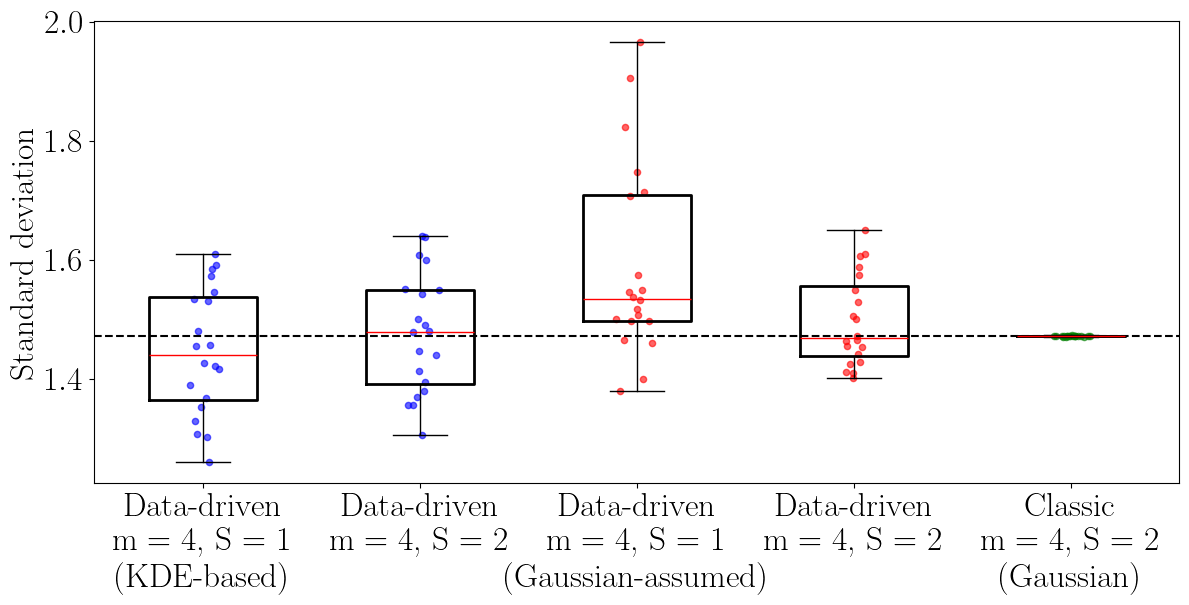

In [20]:
# ==============================================================================
# Visualization: Boxplot of Estimated Standard Deviation
# ==============================================================================

# 1. Figure Style Configuration (User's Original Settings)
plt.style.use('default')
plt.rcParams['text.usetex'] = True   
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24

# 2. Data Preparation
# Fetching 'std' data from the unified 'results' dictionary
data_std = [
    results['s1']['dd']['std'],            # 1. DD (S=1)
    results['s2']['dd']['std'],            # 2. DD (S=2)
    results['s1']['classic_est']['std'],   # 3. Classic Est (S=1)
    results['s2']['classic_est']['std'],   # 4. Classic Est (S=2)
    results['s2']['classic_true']['std']   # 5. Classic True (S=2)
]

# Apply outlier clipping (Using previously defined function)
clipped_data_std = [clip_to_whisker(np.array(y)) for y in data_std]

# Labels (User's Original Labels)
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Gaussian)'
]

# 3. Plotting
fig, ax = plt.subplots()

# Boxplot
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
ax.boxplot(clipped_data_std, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot (Jitter)
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y, color) in enumerate(zip(clipped_data_std, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

# Reference Line & Labels
ax.set_ylabel('Standard deviation')
# Ensure 'y_MCS' is defined
ax.axhline(np.std(y_MCS), color='black', linestyle='--', label='MCS std')

# Axis Formatting
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

# Optional: Legend (Commented out in original code, but recommended)
# ax.legend(loc='upper left') 

plt.show()

In [64]:
# ==============================================================================
# Unified Error Analysis: Mean & Std Relative Errors (Gaussian Case)
# ==============================================================================

# 1. Setup Reference Values (Ground Truth from MCS)
# Ensure 'y_MCS' is defined from the Gaussian simulation step.
true_mean_ref_gauss = np.mean(y_MCS)
true_std_ref_gauss = np.std(y_MCS)

# 2. Define Methods to Analyze
# Key: Method Name, Value: Path keys in 'results' dictionary
methods_map_gauss = [
    ("Data-driven GPCE (S=1)", 's1', 'dd'),
    ("Data-driven GPCE (S=2)", 's2', 'dd'),
    ("Classic GPCE (S=1, Gaussian)", 's1', 'classic_est'),
    ("Classic GPCE (S=2, Gaussian)", 's2', 'classic_est'),
    ("Classic GPCE (S=2, True Gaussian)", 's2', 'classic_true')
]

# 3. Calculate and Print Statistics
print(f"{'='*105}")
print(f"{'[Gaussian Case] Summary'}")
print(f"{'Method':<35} | {'Mean Error (%) (Avg)':<20} | {'Std Error (%) (Avg)':<20}")
print(f"{'-'*105}")

for label, sparsity_key, method_key in methods_map_gauss:
    # A. Fetch Data
    raw_mean_data = results[sparsity_key][method_key]['mean']
    raw_std_data = results[sparsity_key][method_key]['std']
    
    # B. Apply Outlier Clipping
    clipped_mean = clip_to_whisker(np.array(raw_mean_data))
    clipped_std = clip_to_whisker(np.array(raw_std_data))
    
    # C. Calculate Relative Errors (%)
    mean_errors = np.abs((clipped_mean - true_mean_ref_gauss) / true_mean_ref_gauss) * 100
    std_errors = np.abs((clipped_std - true_std_ref_gauss) / true_std_ref_gauss) * 100
    
    # D. Compute Averages
    avg_mean_err = np.mean(mean_errors)
    avg_std_err = np.mean(std_errors)
    
    # E. Output
    print(f"{label:<35} | {avg_mean_err:.4f}               | {avg_std_err:.4f}")

print(f"{'='*105}")

# Optional: Detailed View
print("\n[Detailed Statistics - Gaussian]")
print(f"{'Method':<35} | {'Type':<5} | {'Min (%)':<10} | {'Max (%)':<10} | {'Mean (%)':<10}")
print("-" * 85)

for label, sparsity_key, method_key in methods_map_gauss:
    clipped_mean = clip_to_whisker(np.array(results[sparsity_key][method_key]['mean']))
    clipped_std = clip_to_whisker(np.array(results[sparsity_key][method_key]['std']))
    
    mean_errs = np.abs((clipped_mean - true_mean_ref_gauss) / true_mean_ref_gauss) * 100
    std_errs = np.abs((clipped_std - true_std_ref_gauss) / true_std_ref_gauss) * 100
    
    print(f"{label:<35} | Mean  | {np.min(mean_errs):.4f}     | {np.max(mean_errs):.4f}     | {np.mean(mean_errs):.4f}")
    print(f"{'':<35} | Std   | {np.min(std_errs):.4f}     | {np.max(std_errs):.4f}     | {np.mean(std_errs):.4f}")
    print("-" * 85)

[Gaussian Case] Summary
Method                              | Mean Error (%) (Avg) | Std Error (%) (Avg) 
---------------------------------------------------------------------------------------------------------
Data-driven GPCE (S=1)              | 0.0013               | 6.2866
Data-driven GPCE (S=2)              | 0.0013               | 5.6823
Classic GPCE (S=1, Gaussian)        | 0.0018               | 9.3498
Classic GPCE (S=2, Gaussian)        | 0.0012               | 4.1862
Classic GPCE (S=2, True Gaussian)   | 0.0000               | 0.0388

[Detailed Statistics - Gaussian]
Method                              | Type  | Min (%)    | Max (%)    | Mean (%)  
-------------------------------------------------------------------------------------
Data-driven GPCE (S=1)              | Mean  | 0.0000     | 0.0036     | 0.0013
                                    | Std   | 0.6335     | 14.4109     | 6.2866
-------------------------------------------------------------------------------------


### Case 2

In [22]:
GPCE_seed_list = [105, 30, 127, 530, 160, 851, 566, 180, 77, 716, 119, 293, 451, 406, 844, 115, 363, 45, 450, 3216]

In [ ]:
# ==============================================================================
# Simulation: Log-Normal Distribution Case
# ==============================================================================

# 1. Parameters
# 'log_mean' and 'log_std' are parameters for the underlying Normal distribution
log_mean_val = 3.398 
LOG_MEAN = [log_mean_val, log_mean_val] 
LOG_STD = 0.1
RHO = 0.5
EPSILON_SCALE = 0.5 # Specific bootstrap noise scale for this case

# Calculate Covariance for the underlying Normal distribution
cov_matrix_log = compute_covariance_matrix([LOG_STD, LOG_STD], RHO, num_vars=2)

# 2. Initialize List
Lognormal_kde_sample_list = []

print("Starting Log-Normal KDE Sampling...")

for seed in GPCE_seed_list:
    # -------------------------------------------------------
    # A. Generate Log-Normal Training Data
    # -------------------------------------------------------
    # 1. Generate Normal samples (LHS)
    z_samples = lhs_normal(50, LOG_MEAN, cov_matrix_log, seed=seed)
    
    # 2. Transform to Log-Normal (exp)
    x_train = np.exp(z_samples)
    
    # (Optional) Generate MCS samples for reference
    # z_MCS = lhs_normal(10000, LOG_MEAN, cov_matrix_log, seed=seed)
    # x_MCS = np.exp(z_MCS)

    # -------------------------------------------------------
    # B. KDE with Bias Correction
    # -------------------------------------------------------
    # Using the updated function with custom 'eps_scale=0.5'
    kde_samples = kde_sampling_with_correction(
        kde_set=x_train, 
        n_samples=500000, 
        seed=seed,
        eps_scale=EPSILON_SCALE
    )
    
    # Store results
    Lognormal_kde_sample_list.append(kde_samples)

print(f"Completed. Generated {len(Lognormal_kde_sample_list)} Log-Normal sample sets.")

In [26]:
# ==============================================================================
# Simulation: Log-Normal Case (Order=4, S=2 & S=1)
# ==============================================================================

# 1. Setup Ground Truth (MCS with Log-Normal)
# Parameters
log_mean_val = 3.398 
LOG_MEAN = [log_mean_val, log_mean_val] 
LOG_STD = 0.1
RHO = 0.5
Y = limit_state_function_math
# Compute Covariance for the underlying Normal distribution
cov_matrix_log = compute_covariance_matrix([LOG_STD, LOG_STD], RHO, num_vars=2)

# Generate MCS samples (Transform: Normal -> Exp -> LogNormal)
z_MCS = lhs_normal(1000000, LOG_MEAN, cov_matrix_log, seed=42)
x_MCS = np.exp(z_MCS)
y_MCS = Y(x_MCS)

true_mean_ref = np.mean(y_MCS)
true_std_ref = np.std(y_MCS)

print(f"Reference MCS (Log-Normal) Mean: {true_mean_ref:.4f}, Std: {true_std_ref:.4f}")

# 2. Initialize Results Containers (Using 'lognormal' key to distinguish)
metrics = ['mean', 'std', 'error_mean', 'error_std']

results_log = {
    's2': {
        'dd': {m: [] for m in metrics}, 
        'classic_est': {m: [] for m in metrics}, 
        'classic_true': {m: [] for m in metrics}
    },
    's1': {
        'dd': {m: [] for m in metrics}, 
        'classic_est': {m: [] for m in metrics}
        # 'classic_true' is excluded for S=1
    }
}

# Parameters
order = 4
sparsities = [2, 1] 

# ==============================================================================
# Main Comparative Loop (Log-Normal)
# ==============================================================================

print("Starting Log-Normal Unified Simulation...")

# Note: 'Lognormal_kde_sample_list' from previous cells is renamed to 'lognormal_kde_sample_list' here for clarity.
# Ensure the list from the previous step is available.
lognormal_kde_sample_list = Lognormal_kde_sample_list 

for i, seed in enumerate(GPCE_seed_list):
    
    # -------------------------------------------------------
    # A. Common Data Generation (Per Seed)
    # -------------------------------------------------------
    # 1. Training Data (Log-Normal)
    z_train = lhs_normal(50, LOG_MEAN, cov_matrix_log, seed=seed)
    x_train = np.exp(z_train)
    y_train = Y(x_train)
    
    # Normalize Training Data (Essential for GPCE in this context)
    x_train_norm = x_train / np.mean(x_train, axis=0)
    
    # 2. Prepare Target Distributions (Input for Basis)
    
    # Method 1: Data-Driven (KDE)
    # Retrieve pre-computed KDE samples and Normalize
    kde_samples = lognormal_kde_sample_list[i]
    kde_samples_norm = kde_samples / np.mean(kde_samples, axis=0)
    
    # Method 2: Classic (Gaussian Assumption)
    # Estimate Gaussian parameters from the Log-Normal training data
    est_mean = np.mean(x_train, axis=0)
    est_cov = np.cov(x_train.T)
    # Generate Gaussian samples (Mismatching distribution assumption)
    est_samples = lhs_normal(500000, est_mean, est_cov, seed=seed)
    est_samples_norm = est_samples / np.mean(est_samples, axis=0)
    
    # Method 3: Classic (True Log-Normal) - Only for S=2
    # Generate True Log-Normal samples
    z_true = lhs_normal(1000000, LOG_MEAN, cov_matrix_log, seed=seed)
    x_true = np.exp(z_true)
    x_true_norm = x_true / np.mean(x_true, axis=0)

    # -------------------------------------------------------
    # B. Run GPCE for S=2 and S=1
    # -------------------------------------------------------
    for S in sparsities:
        key = f's{S}'
        
        # --- Method 1: DD-GPCE (KDE) ---
        mu_dd, var_dd = run_dd_gpce(kde_samples_norm, x_train_norm, y_train, order, S)
        results_log[key]['dd']['mean'].append(mu_dd)
        results_log[key]['dd']['std'].append(np.sqrt(var_dd))
        results_log[key]['dd']['error_mean'].append(abs(mu_dd - true_mean_ref)/true_mean_ref * 100)
        results_log[key]['dd']['error_std'].append(abs(np.sqrt(var_dd) - true_std_ref)/true_std_ref * 100)
        
        # --- Method 2: Classic GPCE (Estimated Gaussian) ---
        mu_cl, var_cl = run_dd_gpce(est_samples_norm, x_train_norm, y_train, order, S)
        results_log[key]['classic_est']['mean'].append(mu_cl)
        results_log[key]['classic_est']['std'].append(np.sqrt(var_cl))
        results_log[key]['classic_est']['error_mean'].append(abs(mu_cl - true_mean_ref)/true_mean_ref * 100)
        results_log[key]['classic_est']['error_std'].append(abs(np.sqrt(var_cl) - true_std_ref)/true_std_ref * 100)
        
        # --- Method 3: Classic GPCE (True Log-Normal) -> Only for S=2 ---
        if S == 2:
            mu_tr, var_tr = run_dd_gpce(x_true_norm, x_train_norm, y_train, order, S)
            results_log[key]['classic_true']['mean'].append(mu_tr)
            results_log[key]['classic_true']['std'].append(np.sqrt(var_tr))
            results_log[key]['classic_true']['error_mean'].append(abs(mu_tr - true_mean_ref)/true_mean_ref * 100)
            results_log[key]['classic_true']['error_std'].append(abs(np.sqrt(var_tr) - true_std_ref)/true_std_ref * 100)

print("Log-Normal Simulation Complete.")

Reference MCS (Log-Normal) Mean: 2499.0360, Std: 1.3380
Starting Log-Normal Unified Simulation...
Log-Normal Simulation Complete.


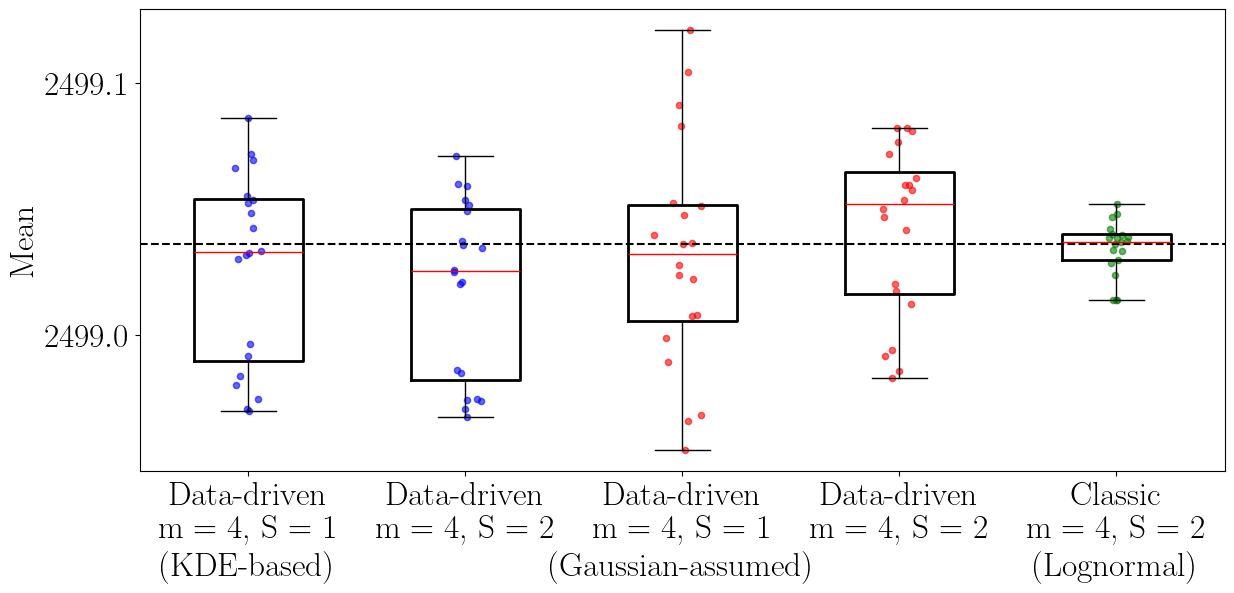

In [27]:
# ==============================================================================
# Visualization: Boxplot of Mean (Log-Normal Case)
# ==============================================================================

# 1. Figure Style Configuration (Original Settings)
plt.style.use('default')
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24

# 2. Data Preparation
# Fetching 'mean' data from the 'results_log' dictionary
data_log_mean = [
    results_log['s1']['dd']['mean'],            # 1. DD (S=1)
    results_log['s2']['dd']['mean'],            # 2. DD (S=2)
    results_log['s1']['classic_est']['mean'],   # 3. Classic Est (S=1)
    results_log['s2']['classic_est']['mean'],   # 4. Classic Est (S=2)
    results_log['s2']['classic_true']['mean']   # 5. Classic True (S=2)
]

# Apply outlier clipping
clipped_data_log = [clip_to_whisker(np.array(y)) for y in data_log_mean]

# Labels (Note: Last label updated to 'Lognormal' as per your snippet)
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Lognormal)'
]

# 3. Plotting
fig, ax = plt.subplots()

# Boxplot
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
ax.boxplot(clipped_data_log, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot (Jitter)
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y, color) in enumerate(zip(clipped_data_log, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

# Reference Line & Labels
ax.set_ylabel('Mean')
# Ensure 'y_MCS' (Log-Normal version) is defined from the previous simulation step
ax.axhline(np.mean(y_MCS), color='black', linestyle='--', label='MCS mean')

# Axis Formatting
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

# Optional: Legend
# ax.legend(loc='upper left')

plt.show()

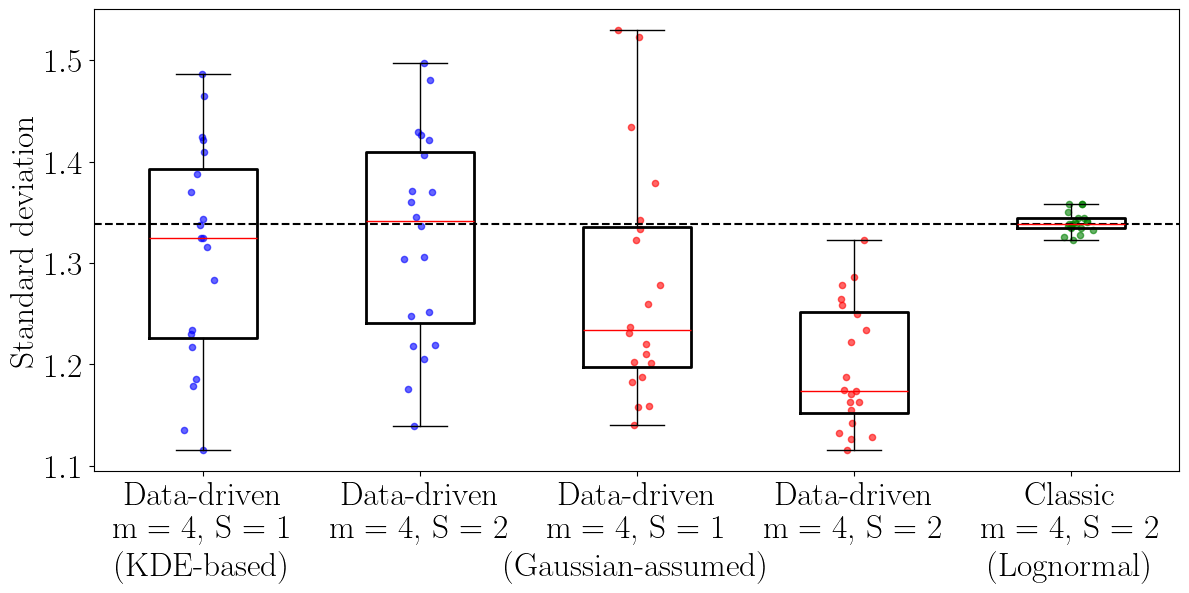

In [32]:
# ==============================================================================
# Visualization: Boxplot of Standard Deviation (Log-Normal Case)
# ==============================================================================

# 1. Figure Style Configuration (User's Original Settings)
plt.style.use('default')
# plt.style.use('default') # Removed duplicate call
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24

# 2. Data Preparation
# Fetching 'std' data from the 'results_log' dictionary
data_log_std = [
    results_log['s1']['dd']['std'],            # 1. DD (S=1)
    results_log['s2']['dd']['std'],            # 2. DD (S=2)
    results_log['s1']['classic_est']['std'],   # 3. Classic Est (S=1)
    results_log['s2']['classic_est']['std'],   # 4. Classic Est (S=2)
    results_log['s2']['classic_true']['std']   # 5. Classic True (S=2)
]

# Apply outlier clipping
clipped_data_log_std = [clip_to_whisker(np.array(y)) for y in data_log_std]

# Labels
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Lognormal)'
]

# 3. Plotting
fig, ax = plt.subplots()

# Boxplot
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
ax.boxplot(clipped_data_log_std, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot (Jitter)
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y, color) in enumerate(zip(clipped_data_log_std, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

# Reference Line & Labels
ax.set_ylabel('Standard deviation')
# Ensure 'y_MCS' is defined from the previous simulation step
ax.axhline(np.std(y_MCS), color='black', linestyle='--', label='MCS std')

# Axis Formatting
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

# Optional: Legend
# ax.legend(loc='upper left')

plt.show()

In [67]:
# ==============================================================================
# Unified Error Analysis: Mean & Std Relative Errors (Log-Normal Case)
# ==============================================================================

# 1. Setup Reference Values
# Ensure 'y_MCS' is defined from the Log-Normal simulation step.

true_mean_ref_log = np.mean(y_MCS)
true_std_ref_log = np.std(y_MCS)

# 2. Define Methods to Analyze
# Key: Method Name, Value: Path keys in 'results_log' dictionary
methods_map_log = [
    ("Data-driven GPCE (S=1)", 's1', 'dd'),
    ("Data-driven GPCE (S=2)", 's2', 'dd'),
    ("Classic GPCE (S=1, Gaussian)", 's1', 'classic_est'),
    ("Classic GPCE (S=2, Gaussian)", 's2', 'classic_est'),
    ("Classic GPCE (S=2, Lognormal)", 's2', 'classic_true')
]

# 3. Calculate and Print Statistics
print(f"\n{'='*105}")
print(f"{'[Log-Normal Case] Summary'}")
print(f"{'Method':<35} | {'Mean Error (%) (Avg)':<20} | {'Std Error (%) (Avg)':<20}")
print(f"{'-'*105}")

for label, sparsity_key, method_key in methods_map_log:
    # A. Fetch Data
    raw_mean_data = results_log[sparsity_key][method_key]['mean']
    raw_std_data = results_log[sparsity_key][method_key]['std']
    
    # B. Apply Outlier Clipping
    clipped_mean = clip_to_whisker(np.array(raw_mean_data))
    clipped_std = clip_to_whisker(np.array(raw_std_data))
    
    # C. Calculate Relative Errors (%)
    mean_errors = np.abs((clipped_mean - true_mean_ref_log) / true_mean_ref_log) * 100
    std_errors = np.abs((clipped_std - true_std_ref_log) / true_std_ref_log) * 100
    
    # D. Compute Averages
    avg_mean_err = np.mean(mean_errors)
    avg_std_err = np.mean(std_errors)
    
    # E. Output
    print(f"{label:<35} | {avg_mean_err:.4f}               | {avg_std_err:.4f}")

print(f"{'='*105}")

# Optional: Detailed View
print("\n[Detailed Statistics - Log-Normal]")
print(f"{'Method':<35} | {'Type':<5} | {'Min (%)':<10} | {'Max (%)':<10} | {'Mean (%)':<10}")
print("-" * 85)

for label, sparsity_key, method_key in methods_map_log:
    clipped_mean = clip_to_whisker(np.array(results_log[sparsity_key][method_key]['mean']))
    clipped_std = clip_to_whisker(np.array(results_log[sparsity_key][method_key]['std']))
    
    mean_errs = np.abs((clipped_mean - true_mean_ref_log) / true_mean_ref_log) * 100
    std_errs = np.abs((clipped_std - true_std_ref_log) / true_std_ref_log) * 100
    
    print(f"{label:<35} | Mean  | {np.min(mean_errs):.4f}     | {np.max(mean_errs):.4f}     | {np.mean(mean_errs):.4f}")
    print(f"{'':<35} | Std   | {np.min(std_errs):.4f}     | {np.max(std_errs):.4f}     | {np.mean(std_errs):.4f}")
    print("-" * 85)


[Log-Normal Case] Summary
Method                              | Mean Error (%) (Avg) | Std Error (%) (Avg) 
---------------------------------------------------------------------------------------------------------
Data-driven GPCE (S=1)              | 0.0012               | 6.6359
Data-driven GPCE (S=2)              | 0.0012               | 6.3629
Classic GPCE (S=1, Gaussian)        | 0.0014               | 8.4531
Classic GPCE (S=2, Gaussian)        | 0.0012               | 10.5011
Classic GPCE (S=2, Lognormal)       | 0.0003               | 0.5545

[Detailed Statistics - Log-Normal]
Method                              | Type  | Min (%)    | Max (%)    | Mean (%)  
-------------------------------------------------------------------------------------
Data-driven GPCE (S=1)              | Mean  | 0.0001     | 0.0026     | 0.0012
                                    | Std   | 0.0531     | 16.6247     | 6.6359
--------------------------------------------------------------------------------

### Case 3

In [43]:
# ==============================================================================
# Data Loading and Reshaping
# ==============================================================================
import numpy as np
import os

# 1. Define File Path
# Using os.path.join ensures compatibility across different operating systems
file_path = os.path.join("./Input samples", "Example 1", "Case 3", "exp_x_true_data.npy")

# 2. Load Raw Data
if os.path.exists(file_path):
    x_true_list = np.load(file_path)
    print(f"Raw data loaded. Shape: {x_true_list.shape}")
else:
    raise FileNotFoundError(f"File not found: {file_path}")

# 3. Reshape Data
# Original Logic:
# - Total 30 blocks
# - Each block has 40,000 elements (First 20,000 = x1, Next 20,000 = x2)
# - Target Shape: (30, 20000, 2)

# Vectorized Approach (No Loop needed):
# Step A: Reshape to (30, 2, 20000) -> Separates x1 and x2 dimensions
# Step B: Transpose (0, 2, 1) -> Moves the variable dimension (2) to the last axis
reshaped_x_true_list = x_true_list.reshape(30, 2, 20000).transpose(0, 2, 1)

print(f"Reshaped data shape: {reshaped_x_true_list.shape}") 
# Expected Output: (30, 20000, 2)

# ==============================================================================
# Construct MCS Dataset for Evaluation
# ==============================================================================

# 1. Flatten the Data
# Original: Stacking 30 blocks of (20000, 2) -> Total (600000, 2)
# Refactored: Reshape directly to (-1, 2) where -1 automatically infers the total rows.
X_MCS = reshaped_x_true_list.reshape(-1, 2)

print(f"X_MCS shape: {X_MCS.shape}") 
# Expected Output: (600000, 2)

# 2. Evaluate Limit State Function
# Ensure the function 'Y' (or 'limit_state_function') is defined.
Y = limit_state_function_math 
Y_MCS = Y(X_MCS)

print(f"Y_MCS shape: {Y_MCS.shape}")

Raw data loaded. Shape: (1200000,)
Reshaped data shape: (30, 20000, 2)
X_MCS shape: (600000, 2)
Y_MCS shape: (600000,)


In [40]:
GPCE_seed_list = [45,450,4555,5545,554564,554568,554569,79656,79652,7945,321,356,4132,3214,3215,3216,3217,3218,3219,6653]

In [56]:
# ==============================================================================
# Simulation: Exponential Distribution Case
# ==============================================================================

# 1. Parameters
EPSILON_SCALE = 0.1 # Bootstrap noise scale for Exponential case

# 2. Initialize List
Exp_kde_sample_list = []

print("Starting Exponential KDE Sampling...")

for seed in GPCE_seed_list:
    # -------------------------------------------------------
    # A. Generate Exponential Training Data
    # -------------------------------------------------------
    x_samples = Exponential_sampling(50, seed=seed)

    # -------------------------------------------------------
    # B. KDE with Bias Correction & Sampling
    # -------------------------------------------------------
    # The complex logic of Grid generation, KDE fitting, Bootstrap loop, 
    # and Fast Inverse Sampling is all encapsulated in this single function.
    kde_sample = kde_sampling_with_correction(
        kde_set=x_samples, 
        n_samples=500000, 
        seed=seed,
        eps_scale=EPSILON_SCALE
    )
    
    # Store results
    Exp_kde_sample_list.append(kde_sample)

print(f"Completed. Generated {len(Exp_kde_sample_list)} Exponential sample sets.")

Starting Exponential KDE Sampling...
Completed. Generated 20 Exponential sample sets.


In [62]:
Exp_kde_sample_list = np.load("./Input samples/Example 1/Case 3/exp_kde_sample_list.npy")

In [57]:
# ==============================================================================
# Simulation: Exponential Case (Order=4, S=2 & S=1)
# ==============================================================================

# 1. Setup Ground Truth (MCS with Exponential)
# Ensure 'X_MCS' and 'Y_MCS' are defined from previous cells.
true_mean_ref = np.mean(Y_MCS)
true_std_ref = np.std(Y_MCS)

print(f"Reference MCS (Exponential) Mean: {true_mean_ref:.4f}, Std: {true_std_ref:.4f}")

# 2. Initialize Results Containers
# Structure: results_exp['s2']['dd']['mean']...
metrics = ['mean', 'std', 'error_mean', 'error_std']

results_exp = {
    's2': {
        'dd': {m: [] for m in metrics}, 
        'classic_est': {m: [] for m in metrics}, 
        'classic_true': {m: [] for m in metrics}
    },
    's1': {
        'dd': {m: [] for m in metrics}, 
        'classic_est': {m: [] for m in metrics}
        # 'classic_true' is excluded for S=1
    }
}

# Parameters
order = 4
sparsities = [2, 1] 

# ==============================================================================
# Main Comparative Loop (Exponential)
# ==============================================================================

print("Starting Exponential Unified Simulation...")

# Ensure 'Exp_kde_sample_list' is available from the previous step.
# Note: Using the list name 'Exp_kde_sample_list' as per your previous request.
kde_sample_list_exp = Exp_kde_sample_list

for i, seed in enumerate(GPCE_seed_list):
    
    # -------------------------------------------------------
    # A. Common Data Generation (Per Seed)
    # -------------------------------------------------------
    # 1. Training Data (Exponential)
    x_train = Exponential_sampling(50, seed=seed)
    y_train = Y(x_train)
    
    # Note: Unlike Gaussian/LogNormal, the provided snippet didn't explicitly show
    # normalization for Exponential x_train. 
    # However, DD-GPCE usually requires basis normalization.
    # If your DD_GPCE function handles normalization internally or if these datasets 
    # don't need it, you can use x_train directly.
    # Here, we assume standard usage and DO NOT normalize x_train based on your snippet,
    # but the basis (samples) might need check.
    # *Logic Check based on your snippet*: You passed 'x_train' raw to DD_GPCE.
    
    # 2. Prepare Target Distributions (Input for Basis)
    
    # Method 1: Data-Driven (KDE)
    kde_samples = kde_sample_list_exp[i]
    # Check if KDE samples need normalization based on your snippet logic
    # Your snippet passed 'kde_sample' directly. We follow that pattern.
    
    # Method 2: Classic (Gaussian Assumption)
    # Estimate Gaussian parameters from the Exponential training data
    est_mean = np.mean(x_train, axis=0)
    est_cov = np.cov(x_train.T)
    # Generate Gaussian samples (Mismatching distribution assumption)
    est_samples = lhs_normal(500000, est_mean, est_cov, seed=seed)
    
    # Method 3: Classic (True Distribution) - Only for S=2
    # Using the pre-generated large-scale X_MCS as the true distribution source
    # or generating new ones if needed. Your snippet used 'X_MCS'.
    true_dist_samples = X_MCS 

    # -------------------------------------------------------
    # B. Run GPCE for S=2 and S=1
    # -------------------------------------------------------
    for S in sparsities:
        key = f's{S}'
        
        # --- Method 1: DD-GPCE (KDE) ---
        mu_dd, var_dd = run_dd_gpce(kde_samples, x_train, y_train, order, S)
        results_exp[key]['dd']['mean'].append(mu_dd)
        results_exp[key]['dd']['std'].append(np.sqrt(var_dd))
        results_exp[key]['dd']['error_mean'].append(abs(mu_dd - true_mean_ref)/true_mean_ref * 100)
        results_exp[key]['dd']['error_std'].append(abs(np.sqrt(var_dd) - true_std_ref)/true_std_ref * 100)
        
        # --- Method 2: Classic GPCE (Estimated Gaussian) ---
        mu_cl, var_cl = run_dd_gpce(est_samples, x_train, y_train, order, S)
        results_exp[key]['classic_est']['mean'].append(mu_cl)
        results_exp[key]['classic_est']['std'].append(np.sqrt(var_cl))
        results_exp[key]['classic_est']['error_mean'].append(abs(mu_cl - true_mean_ref)/true_mean_ref * 100)
        results_exp[key]['classic_est']['error_std'].append(abs(np.sqrt(var_cl) - true_std_ref)/true_std_ref * 100)
        
        # --- Method 3: Classic GPCE (True Exponential) -> Only for S=2 ---
        if S == 2:
            mu_tr, var_tr = run_dd_gpce(true_dist_samples, x_train, y_train, order, S)
            results_exp[key]['classic_true']['mean'].append(mu_tr)
            results_exp[key]['classic_true']['std'].append(np.sqrt(var_tr))
            results_exp[key]['classic_true']['error_mean'].append(abs(mu_tr - true_mean_ref)/true_mean_ref * 100)
            results_exp[key]['classic_true']['error_std'].append(abs(np.sqrt(var_tr) - true_std_ref)/true_std_ref * 100)

print("Exponential Simulation Complete.")

Reference MCS (Exponential) Mean: 2499.9825, Std: 0.0397
Starting Exponential Unified Simulation...
Exponential Simulation Complete.


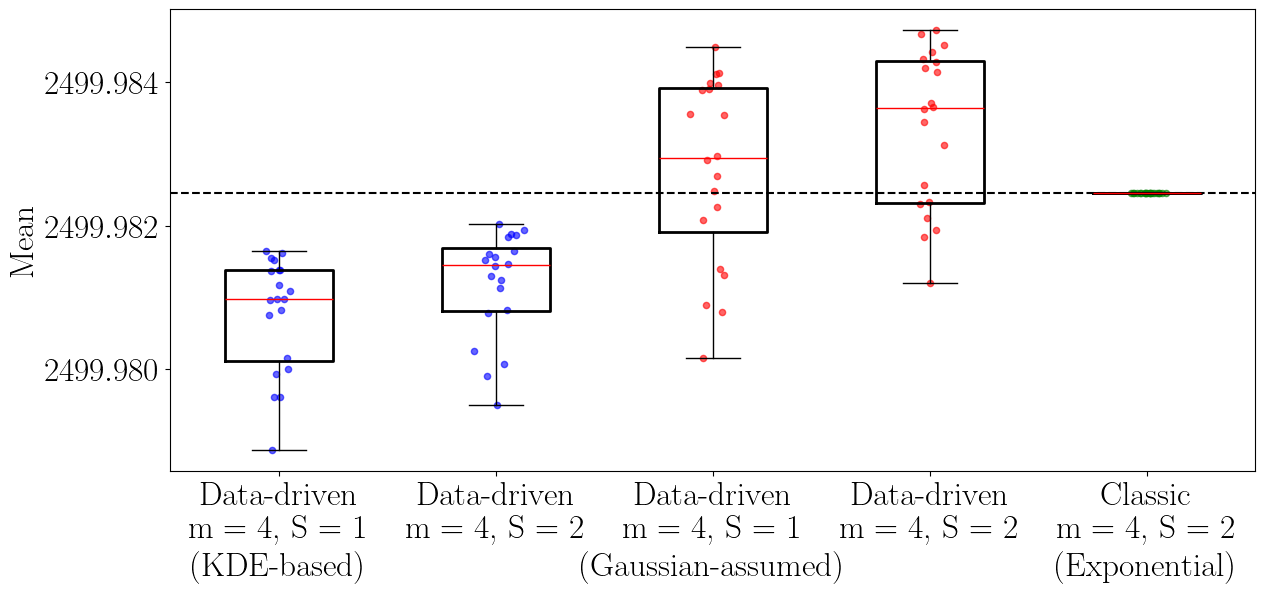

In [58]:
# ==============================================================================
# Visualization: Boxplot of Estimated Mean (Exponential Case)
# ==============================================================================

# 1. Figure Style Configuration
plt.style.use('default')
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24

# 2. Data Preparation
# Fetching 'mean' data from 'results_exp' dictionary
data_exp_mean = [
    results_exp['s1']['dd']['mean'],            # 1. DD (S=1)
    results_exp['s2']['dd']['mean'],            # 2. DD (S=2)
    results_exp['s1']['classic_est']['mean'],   # 3. Classic Est (S=1, Gaussian assumption)
    results_exp['s2']['classic_est']['mean'],   # 4. Classic Est (S=2, Gaussian assumption)
    results_exp['s2']['classic_true']['mean']   # 5. Classic True (S=2, Exponential)
]

# Apply outlier clipping
clipped_data_exp_mean = [clip_to_whisker(np.array(y)) for y in data_exp_mean]

# Labels
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Exponential)'
]

# 3. Plotting
fig, ax = plt.subplots()

# Boxplot
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
ax.boxplot(clipped_data_exp_mean, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot (Jitter)
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y, color) in enumerate(zip(clipped_data_exp_mean, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

# Reference Line & Labels
ax.set_ylabel('Mean')
# Reference: Mean of Y_MCS
ax.axhline(np.mean(Y_MCS), color='black', linestyle='--', label='MCS mean')

# Axis Formatting
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

# Optional Legend
# ax.legend(loc='upper right')

plt.show()

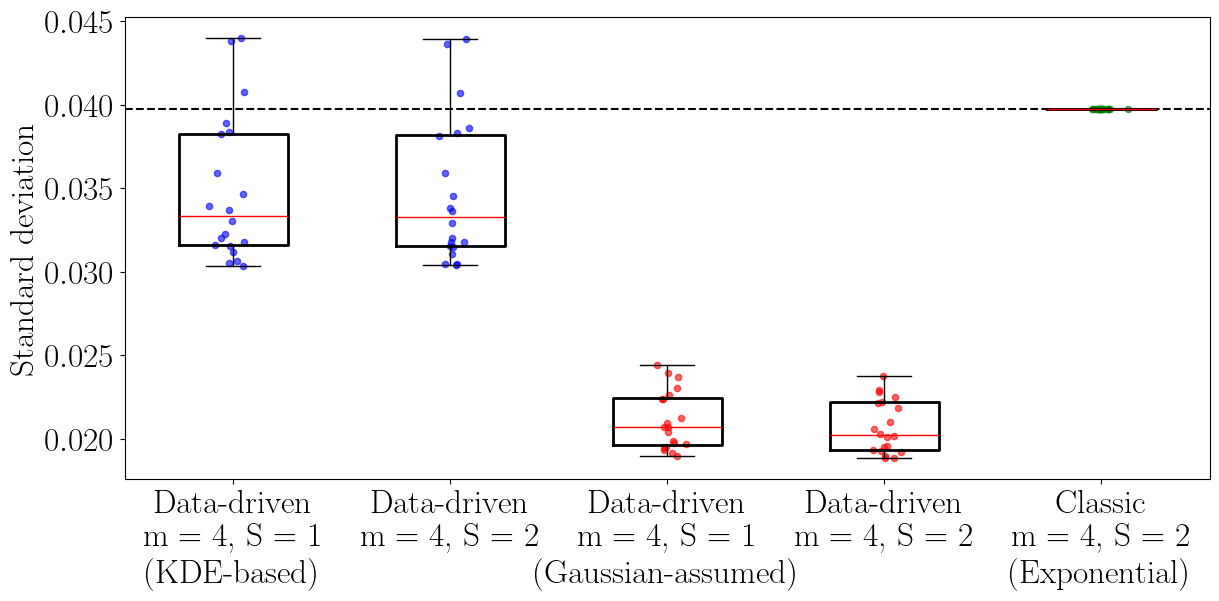

In [59]:
# ==============================================================================
# Visualization: Boxplot of Estimated Std (Exponential Case)
# ==============================================================================

# 1. Figure Style Configuration (Same as above)
plt.style.use('default')
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 24

# 2. Data Preparation
# Fetching 'std' data from 'results_exp' dictionary
data_exp_std = [
    results_exp['s1']['dd']['std'],            # 1. DD (S=1)
    results_exp['s2']['dd']['std'],            # 2. DD (S=2)
    results_exp['s1']['classic_est']['std'],   # 3. Classic Est (S=1)
    results_exp['s2']['classic_est']['std'],   # 4. Classic Est (S=2)
    results_exp['s2']['classic_true']['std']   # 5. Classic True (S=2)
]

# Apply outlier clipping
clipped_data_exp_std = [clip_to_whisker(np.array(y)) for y in data_exp_std]

# Labels (Same as above)
labels = [
    r'Data-driven' + '\n' + r'm = 4, S = 1' +'\n'+'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 4, S = 2',
    'Data-driven\nm = 4, S = 1 \n (Gaussian-assumed)',
    'Data-driven\nm = 4, S = 2',
    'Classic \nm = 4, S = 2 \n (Exponential)'
]

# 3. Plotting
fig, ax = plt.subplots()

# Boxplot
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
ax.boxplot(clipped_data_exp_std, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot (Jitter)
colors = ['blue', 'blue', 'red', 'red', 'green']
for i, (y, color) in enumerate(zip(clipped_data_exp_std, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

# Reference Line & Labels
ax.set_ylabel('Standard deviation')
# Reference: Std of Y_MCS
ax.axhline(np.std(Y_MCS), color='black', linestyle='--', label='MCS std')

# Axis Formatting
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

plt.show()

In [60]:
# ==============================================================================
# Unified Error Analysis: Mean & Std Relative Errors (Exponential Case)
# ==============================================================================

# 1. Setup Reference Values
true_mean_ref = np.mean(Y_MCS)
true_std_ref = np.std(Y_MCS)

# 2. Define Methods to Analyze
# Key: Method Name, Value: Path keys in 'results_exp' dictionary
methods_map_exp = [
    ("Data-driven GPCE (S=1)", 's1', 'dd'),
    ("Data-driven GPCE (S=2)", 's2', 'dd'),
    ("Classic GPCE (S=1, Gaussian)", 's1', 'classic_est'),
    ("Classic GPCE (S=2, Gaussian)", 's2', 'classic_est'),
    ("Classic GPCE (S=2, Exponential)", 's2', 'classic_true')
]

# 3. Calculate and Print Statistics
print(f"{'='*105}")
print(f"{'Method':<35} | {'Mean Error (%) (Avg)':<20} | {'Std Error (%) (Avg)':<20}")
print(f"{'-'*105}")

for label, sparsity_key, method_key in methods_map_exp:
    # A. Fetch Data
    raw_mean_data = results_exp[sparsity_key][method_key]['mean']
    raw_std_data = results_exp[sparsity_key][method_key]['std']
    
    # B. Apply Outlier Clipping
    clipped_mean = clip_to_whisker(np.array(raw_mean_data))
    clipped_std = clip_to_whisker(np.array(raw_std_data))
    
    # C. Calculate Relative Errors (%)
    mean_errors = np.abs((clipped_mean - true_mean_ref) / true_mean_ref) * 100
    std_errors = np.abs((clipped_std - true_std_ref) / true_std_ref) * 100
    
    # D. Compute Averages
    avg_mean_err = np.mean(mean_errors)
    avg_std_err = np.mean(std_errors)
    
    # E. Output
    print(f"{label:<35} | {avg_mean_err:.4f}               | {avg_std_err:.4f}")

print(f"{'='*105}")

# Optional: Detailed View (Min/Max)
print("\n[Detailed Statistics]")
print(f"{'Method':<35} | {'Type':<5} | {'Min (%)':<10} | {'Max (%)':<10} | {'Mean (%)':<10}")
print("-" * 85)

for label, sparsity_key, method_key in methods_map_exp:
    clipped_mean = clip_to_whisker(np.array(results_exp[sparsity_key][method_key]['mean']))
    clipped_std = clip_to_whisker(np.array(results_exp[sparsity_key][method_key]['std']))
    
    mean_errs = np.abs((clipped_mean - true_mean_ref) / true_mean_ref) * 100
    std_errs = np.abs((clipped_std - true_std_ref) / true_std_ref) * 100
    
    print(f"{label:<35} | Mean  | {np.min(mean_errs):.4f}     | {np.max(mean_errs):.4f}     | {np.mean(mean_errs):.4f}")
    print(f"{'':<35} | Std   | {np.min(std_errs):.4f}     | {np.max(std_errs):.4f}     | {np.mean(std_errs):.4f}")
    print("-" * 85)

Method                              | Mean Error (%) (Avg) | Std Error (%) (Avg) 
---------------------------------------------------------------------------------------------------------
Data-driven GPCE (S=1)              | 0.0001               | 14.5847
Data-driven GPCE (S=2)              | 0.0001               | 14.7966
Classic GPCE (S=1, Gaussian)        | 0.0000               | 46.8632
Classic GPCE (S=2, Gaussian)        | 0.0000               | 47.8945
Classic GPCE (S=2, Exponential)     | 0.0000               | 0.0000

[Detailed Statistics]
Method                              | Type  | Min (%)    | Max (%)    | Mean (%)  
-------------------------------------------------------------------------------------
Data-driven GPCE (S=1)              | Mean  | 0.0000     | 0.0001     | 0.0001
                                    | Std   | 2.0685     | 23.6253     | 14.5847
-------------------------------------------------------------------------------------
Data-driven GPCE (S=2)        

## Example 2: a ten-bar truss
### Case 1 ($\rho_{i,j} = 0$)

In [68]:
# Generate GPCE seed list
GPCE_seed_list = [105, 30, 127, 530, 160, 851, 566, 180, 77, 716, 119, 293, 451, 406, 844, 115, 363, 45, 450, 3216]

In [ ]:
# ==============================================================================
# Simulation: 10-Dim Independent Log-Normal Case
# ==============================================================================

# 1. Setup Parameters
N_VARS = 10
MEAN_VAL = 3.39
STD_VAL = 0.14832396974
RHO = 0  # Independent variables

# Define Mean and Covariance
MEAN_VEC = [MEAN_VAL] * N_VARS
COV_MATRIX = compute_covariance_matrix([STD_VAL]*N_VARS, RHO, N_VARS)

# Simulation Settings
N_TRAIN = 350
N_GEN = 500000
kde_sample_matrix_list = []

print(f"Starting 10D KDE Sampling (Train N={N_TRAIN})...")

for seed_idx, seed in enumerate(GPCE_seed_list):
    # -------------------------------------------------------
    # A. Generate Training Data (Log-Normal)
    # -------------------------------------------------------
    # 1. Generate Normal samples (LHS)
    z_samples = lhs_normal(N_TRAIN, MEAN_VEC, COV_MATRIX, seed=seed)
    
    # 2. Transform to Log-Normal
    x_train = np.exp(z_samples)
    
    # -------------------------------------------------------
    # B. Marginal KDE Sampling (Variable by Variable)
    # -------------------------------------------------------
    # Shape: (Num_Variables, Num_Generated_Samples)
    kde_sample_matrix = np.zeros((N_VARS, N_GEN))

    for dim in range(N_VARS):
        # Extract data for current dimension
        data_1d = x_train[:, [dim]]
        
        # Perform 1D KDE + Bootstrap + Sampling
        # Note: Using 'seed + dim' ensures unique randomness for each dimension
        samples_1d = kde_sampling_1d_corrected(
            data_1d=data_1d, 
            n_samples=N_GEN, 
            seed=seed + dim
        )
        
        kde_sample_matrix[dim] = samples_1d

    # Store the result matrix for this trial
    kde_sample_matrix_list.append(kde_sample_matrix)

print(f"Completed. Generated {len(kde_sample_matrix_list)} sample matrices of shape {kde_sample_matrix.shape}.")

In [72]:
kde_sample_matrix_list = np.load("./Input samples/Example 2/Case 1/kde_sample_matrix_list.npy")

In [70]:
# ==============================================================================
# 10-Bar Truss Simulation: Data Loading & Training Set Generation
# ==============================================================================

# 1. Load Pre-computed FEA Results (Ground Truth)
# Using os.path.join for cross-platform compatibility
fea_result_path = os.path.join('./Input samples', 'Example 2', 'Case 1', '10_bar_FEA_Result.npy')

if os.path.exists(fea_result_path):
    YY_MCS = np.load(fea_result_path)
    YU_MCS, YS_MCS = YY_MCS.T
    print(f"Loaded FEA Results. Shape: {YY_MCS.shape}")
else:
    # If file doesn't exist, we might need to generate it or raise error
    print(f"Warning: File not found at {fea_result_path}. Ensure the path is correct.")
    # For robust code, you might want to uncomment below to generate on fly if missing:
    # X_MCS_large = np.exp(lhs_normal(500000, [3.39]*10, compute_covariance_matrix(0.148, 0, 10), seed=42))
    # YY_MCS = np.array([solve_10bar_truss(x) for x in X_MCS_large])

# 2. Simulation Parameters (Log-Normal Distribution)
N_VARS = 10
LOG_MEAN_VAL = 3.39
LOG_STD_VAL = 0.14832396974
RHO = 0  # Independent variables

# Mean Vector & Covariance Matrix
MEAN_VEC = [LOG_MEAN_VAL] * N_VARS
COV_MATRIX = compute_covariance_matrix([LOG_STD_VAL] * N_VARS, RHO, N_VARS)

# 3. Generate Training Data Sets
# Lists to store X (Inputs) and Y (Outputs) for each seed trial
x_train_list = []
y_train_list = []

N_TRAIN = 350
# N_MCS_LOCAL = 500000 (Used in original code as x_true, but not stored. Removed if unused)

print(f"Generating Training Data (N={N_TRAIN}) for {len(GPCE_seed_list)} seeds...")

for seed in GPCE_seed_list:
    # A. Generate Input Samples (LHS -> Log-Normal)
    z_samples = lhs_normal(N_TRAIN, MEAN_VEC, COV_MATRIX, seed=seed)
    x_samples = np.exp(z_samples)
    
    # B. Calculate Responses (Truss Solver)
    # Refactored Function Name: 'RSPSF_TRUSSf2' -> 'solve_10bar_truss'
    # Using list comprehension for cleaner syntax
    y_responses = np.array([solve_10bar_truss(x) for x in x_samples])
    
    # C. Store Data
    x_train_list.append(x_samples)
    y_train_list.append(y_responses)

print("Training data generation complete.")

Loaded FEA Results. Shape: (1000000, 2)
Generating Training Data (N=350) for 20 seeds...
Training data generation complete.


In [78]:
# ==============================================================================
# Unified Simulation: 10-Bar Truss
# Cases:
#   1. m=3, S=1 (Methods: DD, Classic-Est, Classic-True)
#   2. m=2, S=1 (Methods: DD, Classic-Est)
# Outputs: YU (Displacement), YS (Stress)
# ==============================================================================

# 1. Setup Parameters
# List of parameter sets to simulate
param_sets = [
    {'m': 3, 'S': 1, 'id': 'm3s1'},
    {'m': 2, 'S': 1, 'id': 'm2s1'}
]
N_BASIS = 500000

# Setup Ground Truth Statistics (MCS)
ref_stats = {
    'YU': {'mean': np.mean(YU_MCS), 'std': np.std(YU_MCS)},
    'YS': {'mean': np.mean(YS_MCS), 'std': np.std(YS_MCS)}
}

print(f"Reference YU (Mean): {ref_stats['YU']['mean']:.4f}, (Std): {ref_stats['YU']['std']:.4f}")
print(f"Reference YS (Mean): {ref_stats['YS']['mean']:.4f}, (Std): {ref_stats['YS']['std']:.4f}")

# 2. Initialize Results Container
metrics = ['mean', 'std', 'error_mean', 'error_std']

# Structure: results_truss['m3s1']['YU']['dd']['mean']...
results_truss = {}

for p in param_sets:
    pid = p['id']
    results_truss[pid] = {}
    
    # Determine which methods to initialize for this parameter set
    # Classic True is ONLY for m=3, S=1
    current_methods = ['dd', 'classic_est']
    if p['m'] == 3 and p['S'] == 1:
        current_methods.append('classic_true')
        
    for target in ['YU', 'YS']:
        results_truss[pid][target] = {
            method: {k: [] for k in metrics} for method in current_methods
        }

print(f"Starting Truss Simulation for {len(param_sets)} parameter sets...")

# 3. Main Loop
for index, seed in enumerate(GPCE_seed_list):
    
    # -------------------------------------------------------
    # A. Prepare Common Data (Per Seed)
    # -------------------------------------------------------
    # 1. Training Data
    x_train = x_train_list[index]
    y_train = y_train_list[index] 
    x_train_norm = x_train / np.mean(x_train, axis=0)
    
    # 2. Prepare Basis Input Samples (Basis Generation)
    
    # Method 1: Data-Driven (KDE)
    kde_samples = kde_sample_matrix_list[index].T
    basis_samples_dd = kde_samples / np.mean(kde_samples, axis=0)
    
    # Method 2: Classic (Gaussian Assumption)
    est_mean = np.mean(x_train, axis=0)
    est_cov = np.cov(x_train.T)
    gaussian_samples = lhs_normal(N_BASIS, est_mean, est_cov, seed=seed)
    basis_samples_gauss = gaussian_samples / np.mean(gaussian_samples, axis=0)
    
    # Method 3: Classic (True Log-Normal) - Only needed for m=3
    # Use global parameters MEAN_VEC, COV_MATRIX
    z_true = lhs_normal(N_BASIS, MEAN_VEC, COV_MATRIX, seed=seed)
    x_true = np.exp(z_true)
    basis_samples_true = x_true / np.mean(x_true, axis=0)
    
    # Map basis samples to method names
    basis_map = {
        'dd': basis_samples_dd,
        'classic_est': basis_samples_gauss,
        'classic_true': basis_samples_true
    }

    # -------------------------------------------------------
    # B. Run Simulation for Each Parameter Set
    # -------------------------------------------------------
    targets = [('YU', y_train[:, 0]), ('YS', y_train[:, 1])]
    
    for p in param_sets:
        m = p['m']
        S = p['S']
        pid = p['id']
        
        # Define active methods for this (m, S)
        active_methods = ['dd', 'classic_est']
        if m == 3 and S == 1:
            active_methods.append('classic_true')
        
        for label, y_target in targets:
            for method_name in active_methods:
                
                # Select appropriate basis
                current_basis = basis_map[method_name]
                
                # Run GPCE
                mu_est, var_est = run_dd_gpce(current_basis, x_train_norm, y_target, order=m, S=S)
                std_est = np.sqrt(var_est)
                
                # Calculate Errors
                ref_mu = ref_stats[label]['mean']
                ref_std = ref_stats[label]['std']
                
                err_mean = abs(mu_est - ref_mu) / ref_mu * 100
                err_std = abs(std_est - ref_std) / ref_std * 100
                
                # Store Results
                results_truss[pid][label][method_name]['mean'].append(mu_est)
                results_truss[pid][label][method_name]['std'].append(std_est)
                results_truss[pid][label][method_name]['error_mean'].append(err_mean)
                results_truss[pid][label][method_name]['error_std'].append(err_std)

print("Truss Unified Simulation Complete.")

Reference YU (Mean): 0.3630, (Std): 0.0879
Reference YS (Mean): 3842.4461, (Std): 950.0229
Starting Truss Simulation for 2 parameter sets...
Truss Unified Simulation Complete.


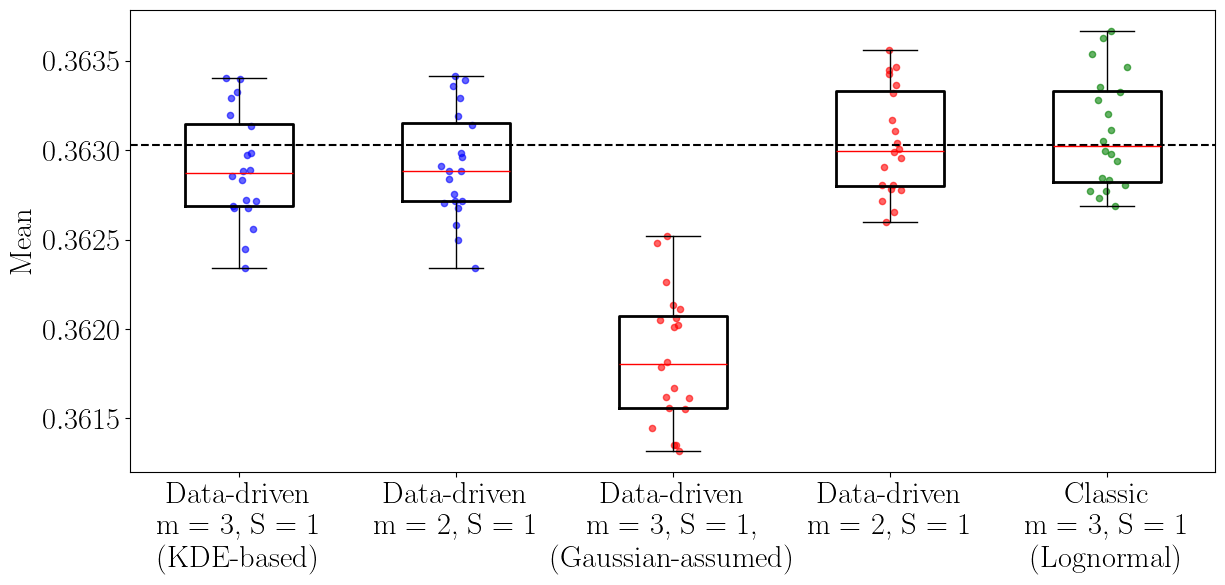

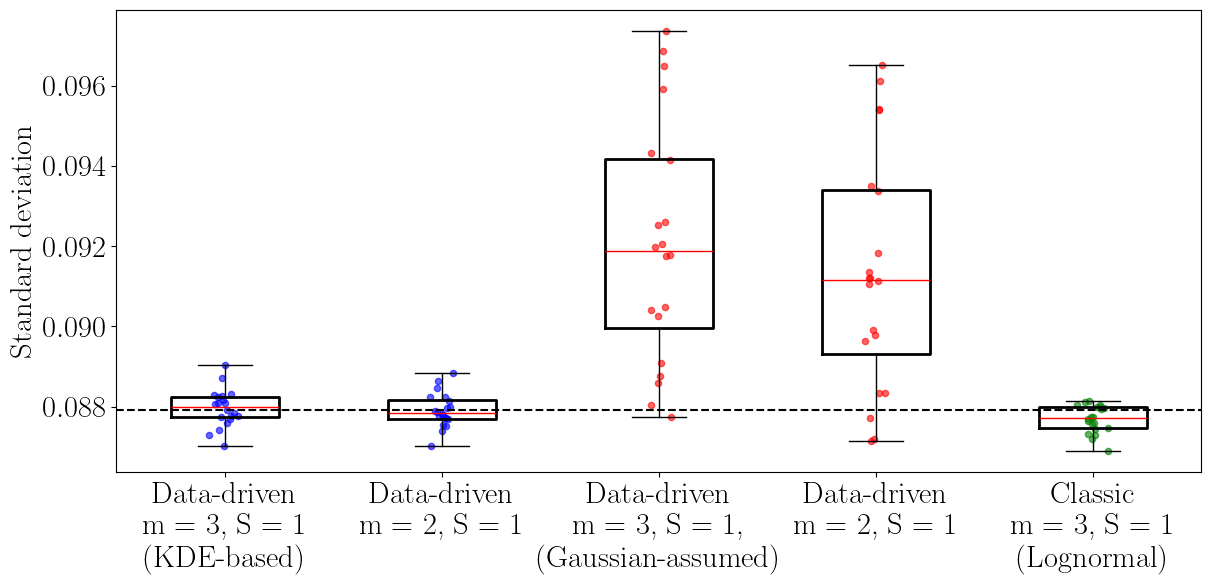

In [80]:
# ==============================================================================
# Visualization: YU (Displacement) - Mean & Std
# Style: User Defined (LaTeX, Boxplot + Scatter)
# ==============================================================================

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# 1. Figure Style Configuration
plt.style.use('default')
plt.rcParams['text.usetex'] = True  
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22

# 2. Common Labels & Colors (User Defined)
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n' + r'(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]
colors = ['blue', 'blue', 'red', 'red', 'green']

# 3. Data Preparation Function
def get_truss_data(target_key, stat_key):
    return [
        results_truss['m3s1'][target_key]['dd'][stat_key],          # 1. DD (m3)
        results_truss['m2s1'][target_key]['dd'][stat_key],          # 2. DD (m2)
        results_truss['m3s1'][target_key]['classic_est'][stat_key], # 3. Gaussian (m3)
        results_truss['m2s1'][target_key]['classic_est'][stat_key], # 4. Gaussian (m2)
        results_truss['m3s1'][target_key]['classic_true'][stat_key] # 5. True (m3)
    ]

# ------------------------------------------------------------------------------
# Plot 1: YU Mean
# ------------------------------------------------------------------------------
data_yu_mean = get_truss_data('YU', 'mean')
clipped_data_yu_mean = [clip_to_whisker(np.array(y)) for y in data_yu_mean]

fig, ax = plt.subplots()
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
ax.boxplot(clipped_data_yu_mean, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot
for i, (y, color) in enumerate(zip(clipped_data_yu_mean, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

ax.set_ylabel('Mean')
# Reference Line (Mean)
ax.axhline(np.mean(YU_MCS), color='black', linestyle='--', label=r'MCS $\mathbb{E}[y_1(\mathbf{X})]$')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

# ax.legend() # Optional
plt.show()

# ------------------------------------------------------------------------------
# Plot 2: YU Standard Deviation
# ------------------------------------------------------------------------------
data_yu_std = get_truss_data('YU', 'std')
clipped_data_yu_std = [clip_to_whisker(np.array(y)) for y in data_yu_std]

fig, ax = plt.subplots()
ax.boxplot(clipped_data_yu_std, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot
for i, (y, color) in enumerate(zip(clipped_data_yu_std, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

ax.set_ylabel('Standard deviation')
# Reference Line (Std)
ax.axhline(np.std(YU_MCS), color='black', linestyle='--', label=r'MCS $\sigma[y_1(\mathbf{X})]$')
# plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

plt.show()

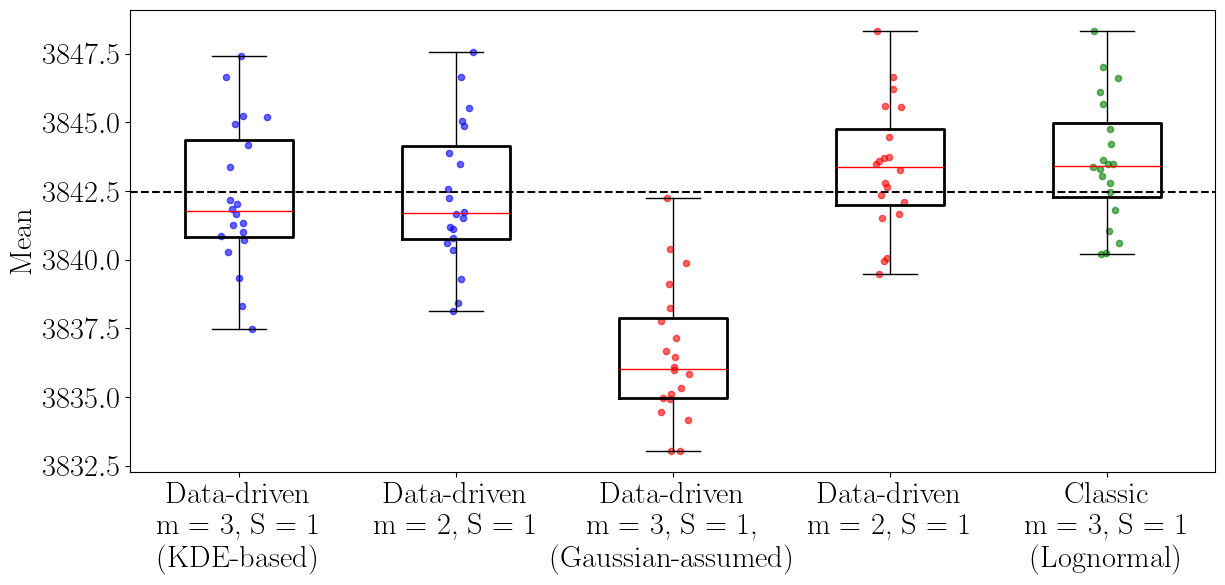

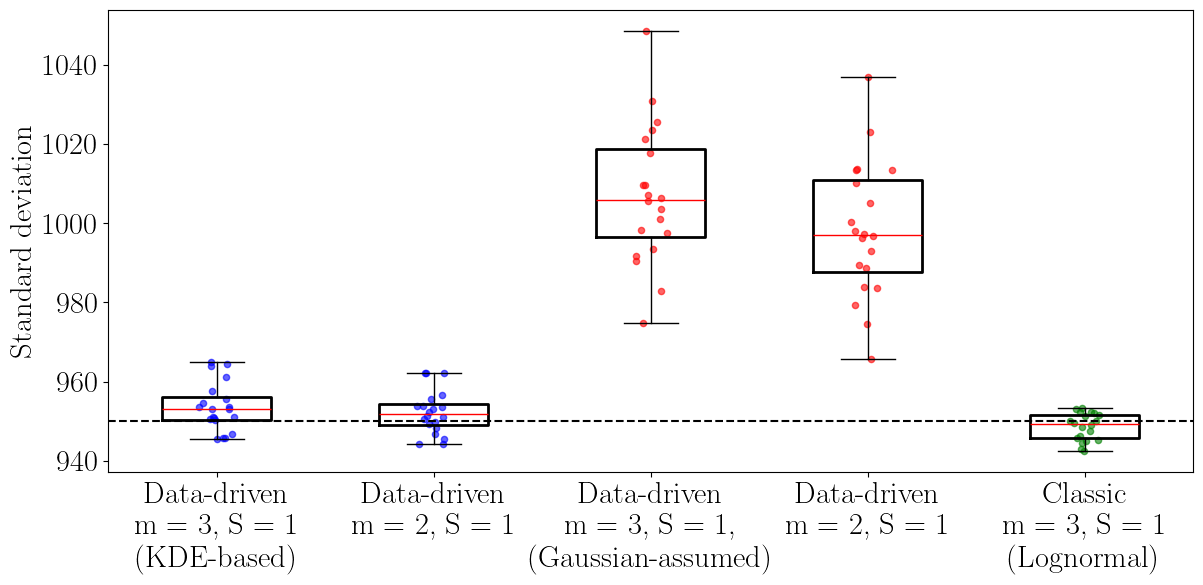

In [81]:
# ==============================================================================
# Visualization: YS (Stress) - Mean & Std
# ==============================================================================

# ------------------------------------------------------------------------------
# Plot 3: YS Mean
# ------------------------------------------------------------------------------
data_ys_mean = get_truss_data('YS', 'mean')
clipped_data_ys_mean = [clip_to_whisker(np.array(y)) for y in data_ys_mean]

fig, ax = plt.subplots()
# Reuse props defined in previous cell
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')

ax.boxplot(clipped_data_ys_mean, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot
for i, (y, color) in enumerate(zip(clipped_data_ys_mean, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

ax.set_ylabel('Mean')
# Reference Line (Mean - YS assumed as y_2)
ax.axhline(np.mean(YS_MCS), color='black', linestyle='--', label=r'MCS $\mathbb{E}[y_2(\mathbf{X})]$')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

plt.show()

# ------------------------------------------------------------------------------
# Plot 4: YS Standard Deviation
# ------------------------------------------------------------------------------
data_ys_std = get_truss_data('YS', 'std')
clipped_data_ys_std = [clip_to_whisker(np.array(y)) for y in data_ys_std]

fig, ax = plt.subplots()
ax.boxplot(clipped_data_ys_std, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter plot
for i, (y, color) in enumerate(zip(clipped_data_ys_std, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x_jitter, y, alpha=0.6, color=color, s=20)

ax.set_ylabel('Standard deviation')
# Reference Line (Std - YS assumed as y_2)
ax.axhline(np.std(YS_MCS), color='black', linestyle='--', label=r'MCS $\sigma[y_2(\mathbf{X})]$')
# plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

plt.show()

In [83]:
# ==============================================================================
# Detailed Error Analysis: 10-Bar Truss (Min, Max, Mean Errors)
# ==============================================================================

import numpy as np

# 1. Define Analysis Targets & Methods
# (Target Key, Display Name, True Mean, True Std)
targets = [
    ('YU', 'Displacement (YU)', np.mean(YU_MCS), np.std(YU_MCS)),
    ('YS', 'Stress (YS)', np.mean(YS_MCS), np.std(YS_MCS))
]

# Analysis Order (ParameterID, MethodKey, DisplayLabel)
analysis_order = [
    ('m3s1', 'dd', 'Data-driven (m=3, S=1)'),
    ('m2s1', 'dd', 'Data-driven (m=2, S=1)'),
    ('m3s1', 'classic_est', 'Data-driven Gauss (m=3, S=1)'),
    ('m2s1', 'classic_est', 'Data-driven Gauss (m=2, S=1)'),
    ('m3s1', 'classic_true', 'Classic Lognormal (m=3, S=1)')
]

# 2. Generate Detailed Tables
for target_key, target_name, true_mean, true_std in targets:
    print(f"\n{'#'*100}")
    print(f" TARGET: {target_name}")
    print(f"{'#'*100}")

    # -------------------------------------------------------
    # Part A: Relative Error of MEAN Estimation
    # -------------------------------------------------------
    print(f"\n[1] Relative Error of MEAN Estimation (%)")
    print(f"{'-'*100}")
    print(f"{'Method':<35} | {'Min (%)':<15} | {'Max (%)':<15} | {'Avg (%)':<15}")
    print(f"{'-'*100}")

    for pid, method, label in analysis_order:
        # Fetch & Clip Data
        raw_mean = results_truss[pid][target_key][method]['mean']
        clipped_mean = clip_to_whisker(np.array(raw_mean))
        
        # Calculate Relative Errors
        mean_errs = np.abs((clipped_mean - true_mean) / true_mean) * 100
        
        # Calculate Stats
        min_err = np.min(mean_errs)
        max_err = np.max(mean_errs)
        avg_err = np.mean(mean_errs)
        
        print(f"{label:<35} | {min_err:.4f}          | {max_err:.4f}          | {avg_err:.4f}")

    print(f"{'-'*100}")

    # -------------------------------------------------------
    # Part B: Relative Error of STD Estimation
    # -------------------------------------------------------
    print(f"\n[2] Relative Error of STD Estimation (%)")
    print(f"{'-'*100}")
    print(f"{'Method':<35} | {'Min (%)':<15} | {'Max (%)':<15} | {'Avg (%)':<15}")
    print(f"{'-'*100}")

    for pid, method, label in analysis_order:
        # Fetch & Clip Data
        raw_std = results_truss[pid][target_key][method]['std']
        clipped_std = clip_to_whisker(np.array(raw_std))
        
        # Calculate Relative Errors
        std_errs = np.abs((clipped_std - true_std) / true_std) * 100
        
        # Calculate Stats
        min_err = np.min(std_errs)
        max_err = np.max(std_errs)
        avg_err = np.mean(std_errs)
        
        print(f"{label:<35} | {min_err:.4f}          | {max_err:.4f}          | {avg_err:.4f}")
    
    print(f"{'='*100}\n")


####################################################################################################
 TARGET: Displacement (YU)
####################################################################################################

[1] Relative Error of MEAN Estimation (%)
----------------------------------------------------------------------------------------------------
Method                              | Min (%)         | Max (%)         | Avg (%)        
----------------------------------------------------------------------------------------------------
Data-driven (m=3, S=1)              | 0.0121          | 0.1889          | 0.0789
Data-driven (m=2, S=1)              | 0.0118          | 0.1897          | 0.0765
Data-driven Gauss (m=3, S=1)        | 0.1409          | 0.4715          | 0.3285
Data-driven Gauss (m=2, S=1)        | 0.0036          | 0.1458          | 0.0683
Classic Lognormal (m=3, S=1)        | 0.0065          | 0.1756          | 0.0726
------------------------------

### Case 2 ($\rho_{i,j} = 0.4$)

In [84]:
GPCE_seed_list = [105, 30, 127, 530, 160, 851, 566, 180, 77, 716, 119, 293, 451, 406, 844, 115, 363, 45, 450, 3216]

In [87]:
# ==============================================================================
# Simulation Case 2: Correlated Inputs (rho = 0.4)
# ==============================================================================

# 1. Setup Parameters (Correlated Log-Normal)
N_VARS = 10
LOG_MEAN_VAL = 3.39
LOG_STD_VAL = 0.14832396974
RHO_COR = 0.4  # Correlation Coefficient

# Mean Vector & Covariance Matrix
MEAN_VEC = [LOG_MEAN_VAL] * N_VARS
COV_MATRIX_COR = compute_covariance_matrix([LOG_STD_VAL] * N_VARS, RHO_COR, N_VARS)

# 2. Load MCS Results (Ground Truth)
# Prioritize loading from file to save time.
mcs_file_path = os.path.join("./Input samples", "Example 2", "Case 2", "cor_10_bar_FEA_result.npy")

if os.path.exists(mcs_file_path):
    y_mcs_cor = np.load(mcs_file_path)
    print(f"Loaded Correlated MCS Results. Shape: {y_mcs_cor.shape}")
else:
    print(f"Warning: File not found at {mcs_file_path}.")
    print("Generating MCS data on the fly (This may take time)...")
    # Fallback: Generate if file missing
    z_mcs = lhs_normal(1000000, MEAN_VEC, COV_MATRIX_COR, seed=4245)
    x_mcs_cor = np.exp(z_mcs)
    y_mcs_cor = np.array([solve_10bar_truss(x) for x in x_mcs_cor])

# Extract Outputs
YU_cor_mcs = y_mcs_cor[:, 0] # Displacement
YS_cor_mcs = y_mcs_cor[:, 1] # Stress

# Calculate Reference Statistics
ref_stats_cor = {
    'YU': {'mean': np.mean(YU_cor_mcs), 'std': np.std(YU_cor_mcs), 'var': np.var(YU_cor_mcs)},
    'YS': {'mean': np.mean(YS_cor_mcs), 'std': np.std(YS_cor_mcs), 'var': np.var(YS_cor_mcs)}
}

print(f"Reference YU (Correlated) - Mean: {ref_stats_cor['YU']['mean']:.4f}, Var: {ref_stats_cor['YU']['var']:.4f}")
print(f"Reference YS (Correlated) - Mean: {ref_stats_cor['YS']['mean']:.4f}, Var: {ref_stats_cor['YS']['var']:.4f}")


# 3. Generate Training Samples (Correlated)
x_train_list_cor = []
y_train_list_cor = []
N_TRAIN = 350

print(f"Generating Correlated Training Data (N={N_TRAIN}) for {len(GPCE_seed_list)} seeds...")

for seed in GPCE_seed_list:
    # A. Generate Correlated Inputs
    z_samples = lhs_normal(N_TRAIN, MEAN_VEC, COV_MATRIX_COR, seed=seed)
    x_samples = np.exp(z_samples)
    
    # B. Calculate Responses
    y_responses = np.array([solve_10bar_truss(x) for x in x_samples])
    
    # C. Store
    x_train_list_cor.append(x_samples)
    y_train_list_cor.append(y_responses)

print("Correlated Training Data Generation Complete.")

Loaded Correlated MCS Results. Shape: (1000000, 2)
Reference YU (Correlated) - Mean: 0.3608, Var: 0.0205
Reference YS (Correlated) - Mean: 3836.4397, Var: 975169.0510
Generating Correlated Training Data (N=350) for 20 seeds...
Correlated Training Data Generation Complete.


In [ ]:
# ==============================================================================
# Hybrid Symbolic-Numeric Moment Matrix Construction for Correlated Inputs
# ==============================================================================

# 1. Configuration
N = 10
m = 3
S = 1
n_gen_samples = 1000000

# 2. Build Symbolic Basis
variables, P, G_symbolic = build_symbolic_basis(N, m, S)
print(f"Basis size: {len(P)}")
# display(G_symbolic) # If in Jupyter

# 3. Setup Correlated Inputs
mean_vec = [3.39] * N
std_dev = 0.14832396974
corr_coef = 0.4
cov_matrix = compute_covariance_matrix(std_dev, corr_coef, N)

G_numeric_list = []

# 4. Process Each Seed
for seed in GPCE_seed_list:
    print(f"Processing Seed: {seed}")
    
    # A. Generate Training Data
    # Assuming lhs_normal returns (N_samples, N_vars)
    z_samples = lhs_normal(350, mean_vec, cov_matrix, seed=seed)
    x_samples = np.exp(z_samples)
    
    # Note: Y_list calculation removed as it wasn't used for G matrix construction
    
    # B. Compute Numeric Moment Matrix
    G_num = compute_numeric_moment_matrix(G_symbolic, variables, x_samples, n_gen_samples)
    
    G_numeric_list.append(G_num)

print("Calculation Complete.")

In [ ]:
# ==============================================================================
# Simulation: Correlated Case (m=3, S=1) using Pre-computed G
# ==============================================================================

import os
import numpy as np

# 1. Setup Parameters
m = 3
S = 1
N_SAMPLES_G = 1000000  # Number of samples used for G (for reference)

# Reference Statistics (from previous cell)
# ref_stats_cor['YU'] and ref_stats_cor['YS'] should be available

# 2. Initialize Results Container
metrics = ['mean', 'std', 'error_mean', 'error_std']
results_cor = {
    'YU': {'dd': {k: [] for k in metrics}},
    'YS': {'dd': {k: [] for k in metrics}}
}

print(f"Starting Correlated DD-GPCE (m={m}, S={S}) with Pre-computed G...")

# 3. Main Loop
for index, seed in enumerate(GPCE_seed_list):
    
    # -------------------------------------------------------
    # A. Prepare Training Data
    # -------------------------------------------------------
    # Using pre-generated lists from the previous step
    x_train = x_train_list_cor[index]
    y_train = y_train_list_cor[index]
    
    # Normalize Training Data (Basis normalization)
    x_train_norm = x_train / np.mean(x_train, axis=0)

    # -------------------------------------------------------
    # B. Load & Condition Moment Matrix (G)
    # -------------------------------------------------------
    # Construct file path safely
    g_file_name = f'DD_GPCE_G_values_{m}_{S}_silverman_million_1std_01eps_{seed}.npy'
    g_file_path = os.path.join('./Input samples', 'Example 2', 'Case 2', 'G_numeric', g_file_name)
    
    if not os.path.exists(g_file_path):
        print(f"Error: G matrix file not found for seed {seed} at {g_file_path}")
        continue
        
    G = np.load(g_file_path)

    # Eigenvalue Correction (Ensure Positive Definiteness)
    eigvals, eigvecs = np.linalg.eigh(G)
    eigvals_corrected = np.maximum(eigvals, 1e-14)
    G_posdef = eigvecs @ np.diag(eigvals_corrected) @ eigvecs.T
    
    # Cholesky Decomposition & Whitening Matrix
    try:
        Q = np.linalg.cholesky(G_posdef)
        W = np.linalg.inv(Q)
    except np.linalg.LinAlgError:
        print(f"Cholesky failed for seed {seed}. Skipping.")
        continue

    # -------------------------------------------------------
    # C. Coefficient Estimation (Least Squares)
    # -------------------------------------------------------
    # Generate Basis on Training Data
    P_train = DD_GenP(x_train_norm, m, S)
    
    # Construct System Matrix A = (W * P_train)^T
    A = (W @ P_train).T
    
    # Pre-compute Pseudo-Inverse: (A^T A)^-1 A^T
    # Using pinv is generally more stable than inv(A.T @ A)
    # C_operator = np.linalg.inv(A.T @ A) @ A.T 
    # Use lstsq for better numerical stability:
    
    # Define Targets: YU (Displacement), YS (Stress)
    targets = [('YU', y_train[:, 0]), ('YS', y_train[:, 1])]
    
    for label, y_target in targets:
        # Solve C = C_operator @ y_target
        # Or using lstsq directly: A * C_whitened = B  => C = W.T * C_whitened (Conceptually)
        # Your original code: C = inv(A.T A) A.T B
        
        # Original Logic:
        C_coeffs = np.linalg.inv(A.T @ A) @ A.T @ y_target
        
        # -------------------------------------------------------
        # D. Statistics & Error Calculation
        # -------------------------------------------------------
        # Mean = First Coefficient
        est_mean = C_coeffs[0]
        
        # Variance = Sum of squares of other coefficients
        # Note: Your code used sum(C[1:]**2). 
        # Theoretically, if orthogonal, Var = sum(C[1:]**2). 
        # With G_numeric approx, this holds closely.
        est_var = np.sum(C_coeffs[1:]**2)
        est_std = np.sqrt(est_var)
        
        # Reference Values
        ref_mean = ref_stats_cor[label]['mean']
        ref_std = ref_stats_cor[label]['std']
        
        # Calculate Errors
        err_mean = np.abs(est_mean - ref_mean) / ref_mean * 100
        err_std = np.abs(est_std - ref_std) / ref_std * 100
        
        # Store Results
        results_cor[label]['dd']['mean'].append(est_mean)
        results_cor[label]['dd']['std'].append(est_std)
        results_cor[label]['dd']['error_mean'].append(err_mean)
        results_cor[label]['dd']['error_std'].append(err_std)

print("Correlated DD-GPCE Simulation Complete.")

In [88]:
# ==============================================================================
# Unified Simulation: Correlated Case
# Methods:
#   1. DD (KDE-based)
#   2. Classic Est (Gaussian-assumed)
#   3. Classic True (Log-Normal) -> Only for m=3
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. Helper Function: Core Solver (Reused)
# ------------------------------------------------------------------------------
def solve_gpce_core(G_matrix, x_train_norm, y_target, m, S):
    """
    Solves GPCE coefficients given a Moment Matrix (G).
    """
    try:
        # Matrix Conditioning & Cholesky
        eigvals, eigvecs = np.linalg.eigh(G_matrix)
        eigvals_corrected = np.maximum(eigvals, 1e-14)
        G_posdef = eigvecs @ np.diag(eigvals_corrected) @ eigvecs.T
        
        Q = np.linalg.cholesky(G_posdef)
        W = np.linalg.inv(Q)
        
        # Coefficient Estimation
        P_train = DD_GenP(x_train_norm, m, S)
        A = (W @ P_train).T
        
        # Solve using pseudoinverse for stability
        C_coeffs = np.linalg.pinv(A.T @ A) @ A.T @ y_target
        
        # Statistics
        est_mean = C_coeffs[0]
        est_var = np.sum(C_coeffs[1:]**2)
        est_std = np.sqrt(max(est_var, 0))
        
        return est_mean, est_std
        
    except np.linalg.LinAlgError:
        return None, None

# ------------------------------------------------------------------------------
# 2. Setup Parameters & Containers
# ------------------------------------------------------------------------------
S = 1 
N_BASIS_SAMPLES = 1000000

# Define Parameter Sets
param_sets = [
    {'m': 3, 'id': 'm3s1'},
    {'m': 2, 'id': 'm2s1'}
]

# Initialize Results Dictionary
metrics = ['mean', 'std', 'error_mean', 'error_std']
results_cor = {}

for p in param_sets:
    pid = p['id']
    # Determine applicable methods for this parameter set
    # 'classic_true' is ONLY added if m=3
    current_methods = ['dd', 'classic_est']
    if p['m'] == 3:
        current_methods.append('classic_true')
        
    results_cor[pid] = {
        'YU': {m: {k: [] for k in metrics} for m in current_methods},
        'YS': {m: {k: [] for k in metrics} for m in current_methods}
    }

# Reference Statistics
ref_stats_cor = {
    'YU': {'mean': np.mean(YU_cor_mcs), 'std': np.std(YU_cor_mcs)},
    'YS': {'mean': np.mean(YS_cor_mcs), 'std': np.std(YS_cor_mcs)}
}

print(f"Starting Correlated Simulation (DD, Gaussian, True)...")

# ------------------------------------------------------------------------------
# 3. Main Loop
# ------------------------------------------------------------------------------
for index, seed in enumerate(GPCE_seed_list):
    
    # A. Prepare Training Data
    x_train = x_train_list_cor[index]
    y_train = y_train_list_cor[index]
    x_train_norm = x_train / np.mean(x_train, axis=0) 

    # -------------------------------------------------------
    # B. Prepare Master Moment Matrices (m=3)
    # -------------------------------------------------------
    
    # [Source 1] Data-Driven (KDE) - Load from File
    g_file_name = f'DD_GPCE_G_values_3_1_silverman_million_1std_01eps_{seed}.npy'
    g_file_path = os.path.join('./Input samples', 'Example 2', 'Case 2', 'G_numeric', g_file_name)
    
    if os.path.exists(g_file_path):
        G_master_dd = np.load(g_file_path)
    else:
        print(f"Warning: KDE G matrix missing for seed {seed}. Skipping KDE.")
        G_master_dd = None

    # [Source 2] Classic Est (Gaussian Assumed) - Calc on fly
    est_mean = np.mean(x_train, axis=0)
    est_cov = np.cov(x_train.T)
    gauss_samples = lhs_normal(N_BASIS_SAMPLES, est_mean, est_cov, seed=seed)
    gauss_samples_norm = gauss_samples / np.mean(gauss_samples, axis=0)
    
    P_gauss = DD_GenP(gauss_samples_norm, m=3, S=1)
    G_master_gauss = (P_gauss @ P_gauss.T) / N_BASIS_SAMPLES

    # [Source 3] Classic True (True Log-Normal) - Calc on fly
    # Using global MEAN_VEC and COV_MATRIX_COR
    z_true = lhs_normal(N_BASIS_SAMPLES, MEAN_VEC, COV_MATRIX_COR, seed=seed)
    x_true = np.exp(z_true)
    x_true_norm = x_true / np.mean(x_true, axis=0)
    
    P_true = DD_GenP(x_true_norm, m=3, S=1)
    G_master_true = (P_true @ P_true.T) / N_BASIS_SAMPLES

    # Group Matrices
    G_sources = {
        'dd': G_master_dd, 
        'classic_est': G_master_gauss,
        'classic_true': G_master_true
    }

    # -------------------------------------------------------
    # C. Execute for Each Parameter Set
    # -------------------------------------------------------
    for p in param_sets:
        m_curr = p['m']
        pid = p['id']
        
        # Calculate Basis Size for slicing
        dummy_P = DD_GenP(x_train_norm, m_curr, S)
        n_basis = dummy_P.shape[0]

        # Define active methods for this parameter set
        active_methods = ['dd', 'classic_est']
        if m_curr == 3:
            active_methods.append('classic_true')

        # Run Solvers
        targets = [('YU', y_train[:, 0]), ('YS', y_train[:, 1])]
        
        for label, y_target in targets:
            for method in active_methods:
                
                G_current_master = G_sources[method]
                if G_current_master is None: continue 
                
                # 1. Slice Matrix (Reusing m=3 matrix)
                G_sliced = G_current_master[:n_basis, :n_basis]
                
                # 2. Run Solver
                est_mean, est_std = solve_gpce_core(G_sliced, x_train_norm, y_target, m_curr, S)
                
                if est_mean is None: continue # Skip if failed

                # 3. Calculate Error
                ref_mean = ref_stats_cor[label]['mean']
                ref_std = ref_stats_cor[label]['std']
                
                err_mean = np.abs(est_mean - ref_mean) / ref_mean * 100
                err_std = np.abs(est_std - ref_std) / ref_std * 100
                
                # 4. Store Results
                results_cor[pid][label][method]['mean'].append(est_mean)
                results_cor[pid][label][method]['std'].append(est_std)
                results_cor[pid][label][method]['error_mean'].append(err_mean)
                results_cor[pid][label][method]['error_std'].append(err_std)

print("Unified Correlated Simulation Complete.")

Starting Correlated Simulation (DD, Gaussian, True)...
Unified Correlated Simulation Complete.


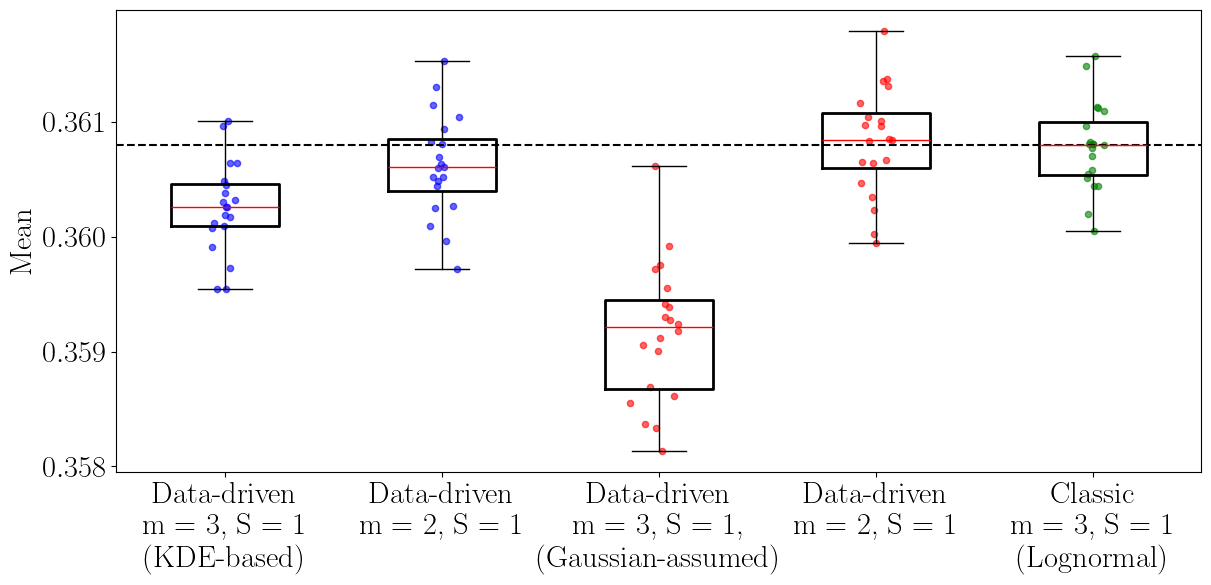

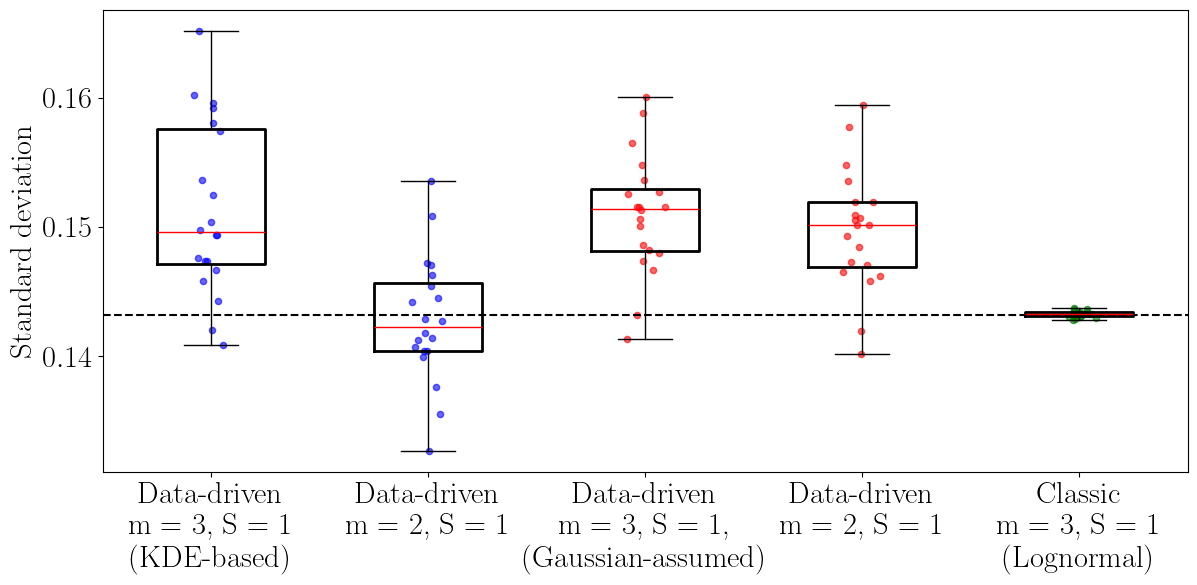

In [89]:
# ==============================================================================
# Visualization: YU (Displacement) - Correlated Case
# ==============================================================================

# 1. Figure Style Configuration
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 22

# 2. Labels & Colors
labels = [
    r'Data-driven' + '\n' + r'm = 3, S = 1' + '\n(KDE-based)',
    r'Data-driven' + '\n' + r'm = 2, S = 1',
    'Data-driven\nm = 3, S = 1, \n (Gaussian-assumed)',
    'Data-driven\nm = 2, S = 1',
    'Classic\nm = 3, S = 1 \n (Lognormal)',
]
colors = ['blue', 'blue', 'red', 'red', 'green']

# 3. Data Extraction Helper
def get_plot_data(target, stat):
    raw_data = [
        results_cor['m3s1'][target]['dd'][stat],           # 1. DD (m3)
        results_cor['m2s1'][target]['dd'][stat],           # 2. DD (m2)
        results_cor['m3s1'][target]['classic_est'][stat],  # 3. Gauss (m3)
        results_cor['m2s1'][target]['classic_est'][stat],  # 4. Gauss (m2)
        results_cor['m3s1'][target]['classic_true'][stat]  # 5. True (m3)
    ]
    return [clip_to_whisker(np.array(d)) for d in raw_data]

# ------------------------------------------------------------------------------
# Plot 1: YU Mean
# ------------------------------------------------------------------------------
data_yu_mean = get_plot_data('YU', 'mean')

fig, ax = plt.subplots()
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')
ax.boxplot(data_yu_mean, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter
for i, (d, c) in enumerate(zip(data_yu_mean, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(d))
    ax.scatter(x_jitter, d, alpha=0.6, color=c, s=20)

ax.set_ylabel('Mean')
ax.axhline(ref_stats_cor['YU']['mean'], color='black', linestyle='--', label=r'MCS $\mathbb{E}[y_1(\mathbf{X})]$')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
plt.show()

# ------------------------------------------------------------------------------
# Plot 2: YU Standard Deviation
# ------------------------------------------------------------------------------
data_yu_std = get_plot_data('YU', 'std')

fig, ax = plt.subplots()
ax.boxplot(data_yu_std, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter
for i, (d, c) in enumerate(zip(data_yu_std, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(d))
    ax.scatter(x_jitter, d, alpha=0.6, color=c, s=20)

ax.set_ylabel('Standard deviation')
ax.axhline(ref_stats_cor['YU']['std'], color='black', linestyle='--', label=r'MCS $\sigma[y_1(\mathbf{X})]$')
# plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
plt.show()

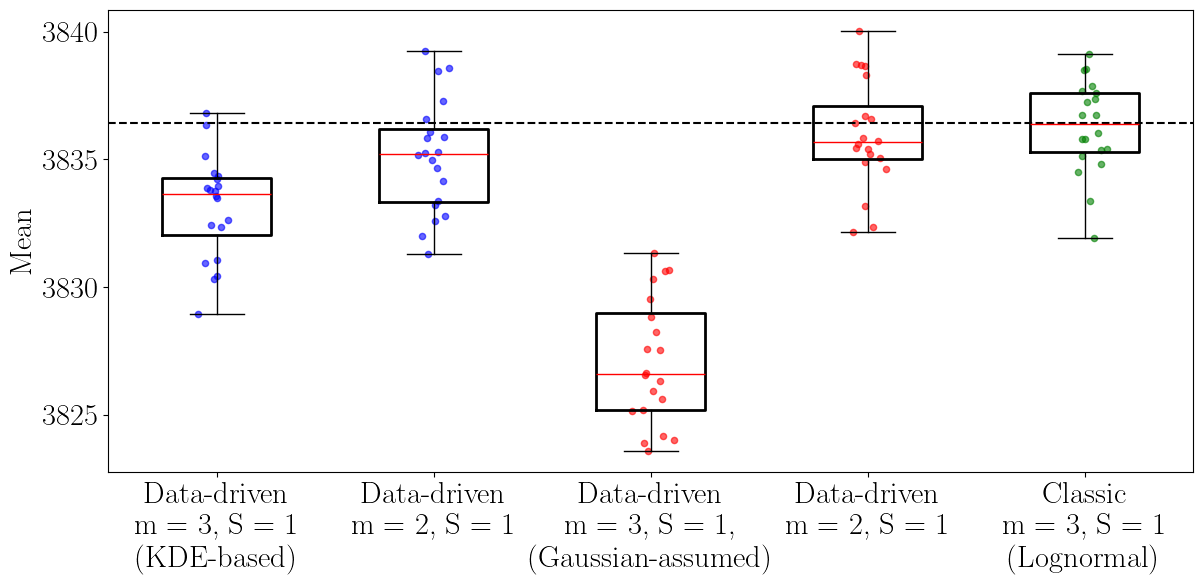

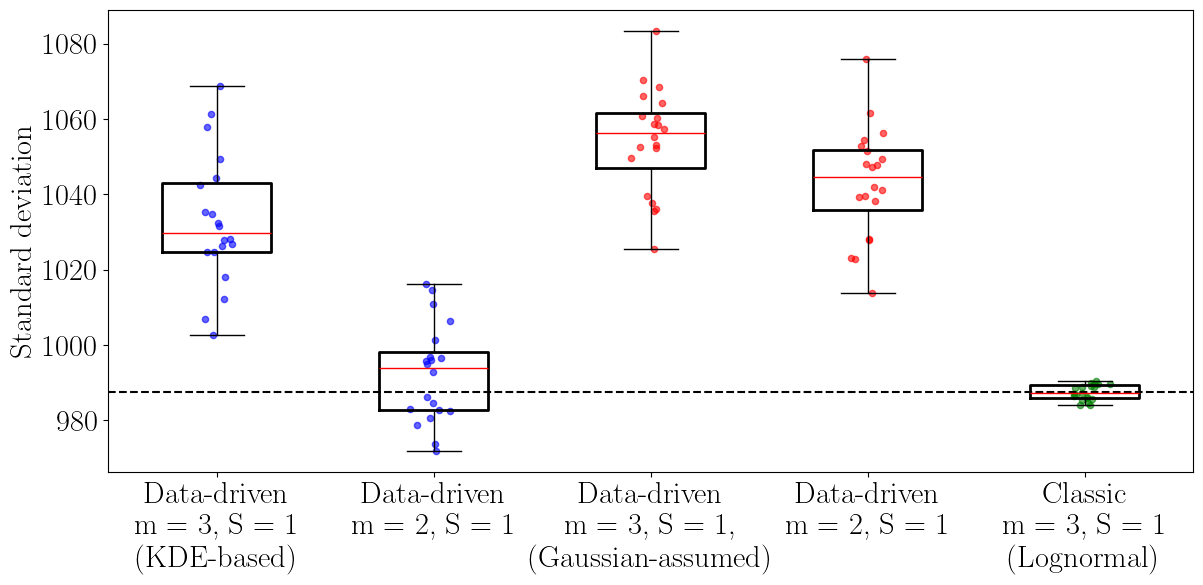

In [90]:
# ==============================================================================
# Visualization: YS (Stress) - Correlated Case
# ==============================================================================

# ------------------------------------------------------------------------------
# Plot 3: YS Mean
# ------------------------------------------------------------------------------
data_ys_mean = get_plot_data('YS', 'mean')

fig, ax = plt.subplots()
# Reuse props
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='r')

ax.boxplot(data_ys_mean, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter
for i, (d, c) in enumerate(zip(data_ys_mean, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(d))
    ax.scatter(x_jitter, d, alpha=0.6, color=c, s=20)

ax.set_ylabel('Mean')
ax.axhline(ref_stats_cor['YS']['mean'], color='black', linestyle='--', label=r'MCS $\mathbb{E}[y_2(\mathbf{X})]$')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
plt.show()

# ------------------------------------------------------------------------------
# Plot 4: YS Standard Deviation
# ------------------------------------------------------------------------------
data_ys_std = get_plot_data('YS', 'std')

fig, ax = plt.subplots()
ax.boxplot(data_ys_std, labels=labels, boxprops=boxprops, medianprops=medianprops)

# Scatter
for i, (d, c) in enumerate(zip(data_ys_std, colors), start=1):
    x_jitter = np.random.normal(i, 0.04, size=len(d))
    ax.scatter(x_jitter, d, alpha=0.6, color=c, s=20)

ax.set_ylabel('Standard deviation')
ax.axhline(ref_stats_cor['YS']['std'], color='black', linestyle='--', label=r'MCS $\sigma[y_2(\mathbf{X})]$')
# plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
plt.show()

In [91]:
# ==============================================================================
# Detailed Error Analysis Table (Correlated Case)
# ==============================================================================

# Configuration
targets = [
    ('YU', 'Displacement (YU)', ref_stats_cor['YU']['mean'], ref_stats_cor['YU']['std']),
    ('YS', 'Stress (YS)', ref_stats_cor['YS']['mean'], ref_stats_cor['YS']['std'])
]

# Order for Table Display
analysis_order = [
    ('m3s1', 'dd', 'Data-driven (m=3, S=1)'),
    ('m2s1', 'dd', 'Data-driven (m=2, S=1)'),
    ('m3s1', 'classic_est', 'Data-driven Gauss (m=3, S=1)'),
    ('m2s1', 'classic_est', 'Data-driven Gauss (m=2, S=1)'),
    ('m3s1', 'classic_true', 'Classic Lognormal (m=3, S=1)')
]

for target_key, target_name, true_mean, true_std in targets:
    print(f"\n{'#'*100}")
    print(f" TARGET: {target_name}")
    print(f"{'#'*100}")

    # --- Part A: Mean Estimation Error ---
    print(f"\n[1] Relative Error of MEAN Estimation (%)")
    print(f"{'-'*100}")
    print(f"{'Method':<35} | {'Min (%)':<15} | {'Max (%)':<15} | {'Avg (%)':<15}")
    print(f"{'-'*100}")

    for pid, method, label in analysis_order:
        raw_mean = results_cor[pid][target_key][method]['mean']
        clipped_mean = clip_to_whisker(np.array(raw_mean))
        
        errs = np.abs((clipped_mean - true_mean) / true_mean) * 100
        
        print(f"{label:<35} | {np.min(errs):.4f}          | {np.max(errs):.4f}          | {np.mean(errs):.4f}")
    print(f"{'-'*100}")

    # --- Part B: Std Estimation Error ---
    print(f"\n[2] Relative Error of STD Estimation (%)")
    print(f"{'-'*100}")
    print(f"{'Method':<35} | {'Min (%)':<15} | {'Max (%)':<15} | {'Avg (%)':<15}")
    print(f"{'-'*100}")

    for pid, method, label in analysis_order:
        raw_std = results_cor[pid][target_key][method]['std']
        clipped_std = clip_to_whisker(np.array(raw_std))
        
        errs = np.abs((clipped_std - true_std) / true_std) * 100
        
        print(f"{label:<35} | {np.min(errs):.4f}          | {np.max(errs):.4f}          | {np.mean(errs):.4f}")
    
    print(f"{'='*100}\n")


####################################################################################################
 TARGET: Displacement (YU)
####################################################################################################

[1] Relative Error of MEAN Estimation (%)
----------------------------------------------------------------------------------------------------
Method                              | Min (%)         | Max (%)         | Avg (%)        
----------------------------------------------------------------------------------------------------
Data-driven (m=3, S=1)              | 0.0444          | 0.3496          | 0.1623
Data-driven (m=2, S=1)              | 0.0006          | 0.3013          | 0.1054
Data-driven Gauss (m=3, S=1)        | 0.0513          | 0.7394          | 0.4550
Data-driven Gauss (m=2, S=1)        | 0.0084          | 0.2740          | 0.1014
Classic Lognormal (m=3, S=1)        | 0.0003          | 0.2138          | 0.0773
------------------------------

## Example 3: Dynamic structural analysis

In [95]:
# ==============================================================================
# Data Loading: Example 3 (Input X & Output Y)
# ==============================================================================

# 1. Helper Function for Data Loading
def load_and_process_csv(file_path, drop_col='index'):
    """
    Loads a CSV file, drops a specific column if it exists, and converts to NumPy array.
    """
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Drop the specified column (e.g., 'index') if present
        if drop_col in df.columns:
            df = df.drop(columns=drop_col)
            
        data_array = df.to_numpy(dtype=float)
        print(f"[Loaded] {os.path.basename(file_path)} | Shape: {data_array.shape}")
        return data_array
    else:
        print(f"[Error] File not found: {file_path}")
        return None

# 2. Define File Paths
# Assuming both files are in the same directory 'Example 3'
base_dir = os.path.join('./Input samples', 'Example 3')

x_file_path = os.path.join(base_dir, 'X_value_1000.csv')
y_file_path = os.path.join(base_dir, 'Y_result_1000.csv')

# 3. Load Data
print("Loading Data for Example 3...")

XX_modal = load_and_process_csv(x_file_path) # Input (Variables)
YY_modal = load_and_process_csv(y_file_path) # Output (Frequencies)

# Check if data loaded correctly
if XX_modal is not None and YY_modal is not None:
    print("\nData loading complete.")
    print(f"Input X shape: {XX_modal.shape}")
    print(f"Output Y shape: {YY_modal.shape}")

Loading Data for Example 3...
[Loaded] X_value_1000.csv | Shape: (996, 20)
[Loaded] Y_result_1000.csv | Shape: (996, 6)

Data loading complete.
Input X shape: (996, 20)
Output Y shape: (996, 6)


In [105]:
# ==============================================================================
# Data Generation: Example 3 (MCS Input Samples)
# Generates inputs by concatenating two Log-Normal groups (Correlated & Uncorrelated)
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. Parameter Setup
# ------------------------------------------------------------------------------
sample_number = 2000000
seed = 76543

# --- Group 1: Correlated Variables (Rho = 0.5) ---
mean_log_normal1 = np.array([1.0] * 7)
std_log_normal1  = np.array([0.06] * 7)

# --- Group 2: Independent Variables (Rho = 0.0) ---
mean_log_normal2 = np.array([
    451.241, 75.287, 196.370, 30.614, 
    4.41e11, 1.67e11, 0.32, 1870.0, 
    2.07e8, 2.07e8, 5.86e8, 15.1, 480.0
])

std_log_normal2 = np.array([
    27.075, 5.0, 9.8, 1.5, 
    2.205e10, 8.35e9, 0.016, 93.5, 
    1.035e7, 1.035e7, 2.93e7, 0.7, 24.0
])

# ------------------------------------------------------------------------------
# 2. Generate Samples
# ------------------------------------------------------------------------------
print(f"Generating {sample_number:,} samples for Example 3...")

# Group 1 Sampling
# sampling returns ln(X), so we apply exp() to get X
ln_X1 = sampling(mean_log_normal1, std_log_normal1**2, 0.5, sample_number, seed)
X1 = np.exp(ln_X1)

# Group 2 Sampling
ln_X2 = sampling(mean_log_normal2, std_log_normal2**2, 0.0, sample_number, seed)
X2 = np.exp(ln_X2)

# Concatenate
XX_MCS_gen = np.concatenate((X1, X2), axis=1)

print("Data Generation Complete.")
print(f"Group 1 Shape: {X1.shape}")
print(f"Group 2 Shape: {X2.shape}")
print(f"Combined MCS Input Shape: {XX_MCS_gen.shape}")

Generating 2,000,000 samples for Example 3...
Data Generation Complete.
Group 1 Shape: (2000000, 7)
Group 2 Shape: (2000000, 13)
Combined MCS Input Shape: (2000000, 20)


In [ ]:
# ==============================================================================
# KDE-based Correction: Example 3 (7D KDE on Correlated Group)
# ==============================================================================

# 1. Select Data (First 7 Columns - Correlated Group)
# Assuming 'XX_modal' is the combined data from the previous step
if 'XX_modal' in locals():
    kde_input_set = XX_modal[:, :7]
else:
    print("[Error] 'XX_modal' not found. Cannot proceed with KDE correction.")
    kde_input_set = None

# 2. Run Correction
# bin_size=8 -> 8^7 = 2,097,152 grid points. 
# n_samples=2,000,000
print(f"Input Data Shape: {kde_input_set.shape}")

samples_1_7, samples_norm_1_7 = run_7d_kde_correction(
    kde_input_set, 
    bin_size=8, 
    n_samples=2000000, 
    seed=42
)

print("7D KDE Correction Complete.")
print(f"Generated Samples Shape: {samples_1_7.shape}")

1. Grid 생성 및 설정 초기화 중...
   - Grid Points 개수: 2,097,152개
2. Original KDE Fitting 진행 중...
3. Bootstrap 시작 (총 100회 반복)
   >> 진행 중: [100/100] (100.0%) 완료
   >> Bootstrap 완료!
4. Sampling 및 정규화 진행 중...
모든 작업 완료.


In [ ]:
# ==============================================================================
# Unified KDE Correction & Sampling (Variables 8 ~ 20)
# Independent variable processing with specific scaling/bandwidth rules
# ==============================================================================

SAMPLE_NUMBER = 2000000
SEED = 456789

# --- Block 1: Variables 8 ~ 11 (Indices 7, 8, 9, 10) ---
print("Processing Group 1 (Vars 8-11)...")
num_variables = 4
kde_sample_matrix1 = np.zeros((num_variables, SAMPLE_NUMBER))

for i in range(num_variables):
    data_col = XX_modal[:, [i + 7]]
    kde_sample_matrix1[i] = run_single_kde_correction(
        data_col, SAMPLE_NUMBER, SEED, 
        scale=1.0, eps=0.1
    )

# --- Block 2: Variables 12 ~ 13 (Indices 11, 12) ---
# Feature: Scaling by 1e10
print("Processing Group 2 (Vars 12-13)...")
num_variables = 2
kde_sample_matrix2 = np.zeros((num_variables, SAMPLE_NUMBER))

for i in range(num_variables):
    data_col = XX_modal[:, [i + 11]]
    kde_sample_matrix2[i] = run_single_kde_correction(
        data_col, SAMPLE_NUMBER, SEED, 
        scale=1e10, eps=0.1
    )

# --- Block 3: Variables 14 ~ 15 (Indices 13, 14) ---
# Feature: Variable 14 (i=0) uses std-adjusted bandwidth
print("Processing Group 3 (Vars 14-15)...")
num_variables = 2
kde_sample_matrix3 = np.zeros((num_variables, SAMPLE_NUMBER))

for i in range(num_variables):
    data_col = XX_modal[:, [i + 13]]
    # Original logic: if i == 0, multiply h by std
    use_std_h = (i == 0)
    
    kde_sample_matrix3[i] = run_single_kde_correction(
        data_col, SAMPLE_NUMBER, SEED, 
        scale=1.0, use_std_bandwidth=use_std_h, eps=0.1
    )

# --- Block 4: Variables 16 ~ 18 (Indices 15, 16, 17) ---
# Feature: Scaling by 1e7
print("Processing Group 4 (Vars 16-18)...")
num_variables = 3
kde_sample_matrix4 = np.zeros((num_variables, SAMPLE_NUMBER))

for i in range(num_variables):
    data_col = XX_modal[:, [i + 15]]
    kde_sample_matrix4[i] = run_single_kde_correction(
        data_col, SAMPLE_NUMBER, SEED, 
        scale=1e7, eps=0.1
    )

# --- Block 5: Variables 19 ~ 20 (Indices 18, 19) ---
print("Processing Group 5 (Vars 19-20)...")
num_variables = 2
kde_sample_matrix5 = np.zeros((num_variables, SAMPLE_NUMBER))

for i in range(num_variables):
    data_col = XX_modal[:, [i + 18]]
    kde_sample_matrix5[i] = run_single_kde_correction(
        data_col, SAMPLE_NUMBER, SEED, 
        scale=1.0, eps=0.1
    )

print("All Independent Variables Processed.")
print(f"Matrix Shapes: {kde_sample_matrix1.shape}, {kde_sample_matrix2.shape}, {kde_sample_matrix3.shape}, {kde_sample_matrix4.shape}, {kde_sample_matrix5.shape}")

In [ ]:
kde_arrayy = np.hstack((samples_norm_1_7, kde_sample_matrix1.T, kde_sample_matrix2.T, kde_sample_matrix3.T, kde_sample_matrix4.T, kde_sample_matrix5.T))
kde_arrayy = np.load('./Input samples/Example 3/kde_arrayy.npy')

In [ ]:
# ==============================================================================
# Unified DD-GPCE Simulation: Example 3 (Modal Frequency, 20D)
# Methods:
#   1. Data-Driven (KDE-based): m=3, S=1
#   2. Data-Driven (Gaussian-Assumed): m=3, S=1
#   3. Classic (True Distribution): m=3, S=1
#   4. Classic (True Distribution): m=2, S=2
# ==============================================================================

# A. Training Data (from CSV)
x_samples = XX_modal  # 
y_samples = YY_modal  # 

# B. Basis Sources
# Source 1: KDE Array (Constructed in previous step)
basis_kde = kde_arrayy

# Source 2: Gaussian Assumed (Generated on the fly)
# Estimate stats from small sample (x_samples)
print("Generating Gaussian Basis...")
est_mean = np.mean(x_samples, axis=0)
est_cov = np.cov(x_samples.T)
basis_gauss = lhs_normal(2000000, est_mean, est_cov, seed=42)
basis_gauss = np.exp(basis_gauss) if False else basis_gauss # Note: lhs_normal returns Normal. If x is LogNormal, we might need transform. 
# However, user code 'estimated_samples' uses lhs_normal directly as samples. 
# Assuming x_samples were already in the target space or lhs_normal fits the target space directly.
# *Correction*: In the user snippet, 'estimated_samples' are generated via lhs_normal. 
# If XX was LogNormal, directly fitting Normal to it is the "Gaussian Assumption". Correct.

# Source 3: True MCS (Generated in Data Generation step)
# Assuming 'XX_MCS_gen' exists (2,000,000 samples from True LogNormal)
if 'XX_MCS_gen' not in locals():
    raise ValueError("XX_MCS_gen (True MCS samples) not found.")
basis_true = XX_MCS_gen


# ------------------------------------------------------------------------------
# 3. Execution of All Cases
# ------------------------------------------------------------------------------
results_ex3 = {}

# Case 1: Data-Driven (KDE) [m=3, S=1]
m, S = 3, 1
mu, std = run_gpce_solver(basis_kde, x_samples, y_samples, m, S, "DD-KDE")
results_ex3['DD-KDE (m=3, S=1)'] = {'mean': mu, 'std': std}

# Case 2: Data-Driven (Gaussian) [m=3, S=1]
m, S = 3, 1
mu, std = run_gpce_solver(basis_gauss, x_samples, y_samples, m, S, "DD-Gauss")
results_ex3['DD-Gauss (m=3, S=1)'] = {'mean': mu, 'std': std}

# Case 3: Classic (True Dist) [m=3, S=1]
m, S = 3, 1
mu, std = run_gpce_solver(basis_true, x_samples, y_samples, m, S, "Classic (m=3)")
results_ex3['Classic (m=3, S=1)'] = {'mean': mu, 'std': std}

# Case 4: Classic (True Dist) [m=2, S=2]
m, S = 2, 2
mu, std = run_gpce_solver(basis_true, x_samples, y_samples, m, S, "Classic (m=2)")
results_ex3['Classic (m=2, S=2)'] = {'mean': mu, 'std': std}


Generating Gaussian Basis...
[DD-KDE] Running GPCE (m=3, S=1)...
[DD-Gauss] Running GPCE (m=3, S=1)...
[Classic (m=3)] Running GPCE (m=3, S=1)...
[Classic (m=2)] Running GPCE (m=2, S=2)...

Method               | Output | Est Mean     | True Mean    | Err(%)   || Est Std      | True Std     | Err(%)  
--------------------------------------------------------------------------------------------------------------
--- DD-KDE (m=3, S=1) ---
  > Avg Mean Error: 0.4609%  (Max: 0.6214%)
  > Avg Std  Error: 11.2020%  (Max: 20.8476%)
                     | Freq 1  | 15.3220      | 15.2413      | 0.5293   || 2.2883       | 1.9890       | 15.0514 
                     | Freq 2  | 27.6730      | 27.6454      | 0.0997   || 2.7191       | 3.0370       | 10.4671 
                     | Freq 3  | 30.4989      | 30.3105      | 0.6214   || 3.8496       | 4.2651       | 9.7420  
                     | Freq 4  | 32.1633      | 31.9987      | 0.5142   || 4.1875       | 4.6434       | 9.8174  
              

In [107]:
# ==============================================================================
# 4. Unified Error Analysis & Reporting (Full 20 Outputs)
# ==============================================================================

true_means = np.mean(y_samples, axis=0)
true_stds = np.std(y_samples, axis=0)

# Print Detailed Comparison Table
print("\n" + "="*110)
print(f"{'Method':<20} | {'Output':<6} | {'Est Mean':<12} | {'True Mean':<12} | {'Err(%)':<8} || {'Est Std':<12} | {'True Std':<12} | {'Err(%)':<8}")
print("-" * 110)

# Iterate over all methods
for method_name, res in results_ex3.items():
    if res['mean'] is None: continue # Skip failed runs
    
    est_means = res['mean']
    est_stds = res['std']
    
    # Calculate Relative Errors
    err_means = np.abs(est_means - true_means) / true_means * 100
    err_stds = np.abs(est_stds - true_stds) / true_stds * 100
    
    # Print Method Summary
    print(f"--- {method_name} ---")
    print(f"  > Avg Mean Error: {np.mean(err_means):.4f}%  (Max: {np.max(err_means):.4f}%)")
    print(f"  > Avg Std  Error: {np.mean(err_stds):.4f}%  (Max: {np.max(err_stds):.4f}%)")
    
    # Print All Individual Outputs
    for i in range(len(est_means)): 
        print(f"{'':<20} | Freq {i+1:<2} | {est_means[i]:<12.4f} | {true_means[i]:<12.4f} | {err_means[i]:<8.4f} || {est_stds[i]:<12.4f} | {true_stds[i]:<12.4f} | {err_stds[i]:<8.4f}")
        
    print("-" * 110)

print("="*110)


Method               | Output | Est Mean     | True Mean    | Err(%)   || Est Std      | True Std     | Err(%)  
--------------------------------------------------------------------------------------------------------------
--- DD-KDE (m=3, S=1) ---
  > Avg Mean Error: 0.4609%  (Max: 0.6214%)
  > Avg Std  Error: 11.2020%  (Max: 20.8476%)
                     | Freq 1  | 15.3220      | 15.2413      | 0.5293   || 2.2883       | 1.9890       | 15.0514 
                     | Freq 2  | 27.6730      | 27.6454      | 0.0997   || 2.7191       | 3.0370       | 10.4671 
                     | Freq 3  | 30.4989      | 30.3105      | 0.6214   || 3.8496       | 4.2651       | 9.7420  
                     | Freq 4  | 32.1633      | 31.9987      | 0.5142   || 4.1875       | 4.6434       | 9.8174  
                     | Freq 5  | 34.5604      | 34.4137      | 0.4263   || 3.8919       | 4.9169       | 20.8476 
                     | Freq 6  | 41.4504      | 41.2136      | 0.5746   || 4.1726       |